## NEXT:
- Clip params in softmax parameterization?

In [106]:
import gym_examples
import numpy as np
import gym

In [107]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 12
rcParams['figure.figsize'] = (10, 4)

In [108]:
def action2str(action):
    left = u'\u2190'
    right = u'\u2192'
    up = u'\u2191'
    down = u'\u2193'
    policy_str = ""
    if 0 == action:
        policy_str += down 
    if 1 == action:
        policy_str += right 
    if 2 == action:
        policy_str += up
    if 3 == action:
        policy_str += left
    return policy_str

def getAngle(arr):
    down, right, up, left = arr
    x = right-left
    y = up-down
    if x > 0 and y >= 0: return np.arctan(y/x) /np.pi*180
    if x < 0 and y >= 0: return 180 - np.arctan(y/abs(x)) /np.pi*180
    if x > 0 and y < 0: return 360 - np.arctan(abs(y)/x) /np.pi*180
    if x < 0 and y < 0: return 180 + np.arctan(abs(y)/abs(x)) /np.pi*180

In [244]:
# Policy is a map from the states to a distribution over actions
# We assume the same actions can be taken from each state and they are
# indexed by integers starting at 0
"""
    size: size of the grid of the environment
    A: number of actions
    S: number of states (not currently used)
"""
class Policy:
    def __init__(self, size, A=0, S=0):
        # Initialise as uniform distribution
        self.S = S
        self.A = A
        self.size = 5
        self.distribution = np.ones((5, 5, A))/A
    
    # sample an action according to the policy in the given state 
    def __call__(self, state):
        return np.random.choice(np.arange(self.A), p=self.distribution[state])
    
    def plotPolicy(self):
        #size = int(np.sqrt(self.S))
        plt.imshow(np.zeros((self.size, self.size)))
        #actions = np.argmax(self.distribution, axis=1)
        for i in range(self.size):
            for j in range(self.size):
                angle = getAngle(self.distribution[i,j])
                plt.text(j, i, u'\u2192', ha="center", va="center", color="r", fontsize=24,
                        rotation=angle, rotation_mode='anchor')
    
class SoftmaxPolicy(Policy):
    def __init__(self, size, A, S=0):
        super().__init__(size, A, S)
        self.params = np.ones((self.size, self.size, self.A))
        
        
    def __call__(self, state):
        p = np.exp(self.params[state]) / np.sum(np.exp(self.params[state]))
        return np.random.choice(np.arange(self.A), p = p)
    
    def plotPolicy(self):
        self.updateDistribution()
        plt.imshow(np.zeros((self.size, self.size)))
        for i in range(self.size):
            for j in range(self.size):
                angle = getAngle(self.distribution[i,j])
                plt.text(j, i, u'\u2192', ha="center", va="center", color="r", fontsize=24,
                        rotation=angle, rotation_mode='anchor')
    
    def normaliseParams(self):
        self.params = self.params - np.repeat(np.reshape(np.mean(self.params, axis=2), (self.size, self.size, 1)), 
                                              self.A, axis=2)
    
    def updateDistribution(self):
        for i in range(self.size):
            for j in range(self.size):
                self.distribution[i,j] = np.exp(self.params[i,j]) / np.sum(np.exp(self.params[i,j]))


# Have to "select" a policy at the start of each episode
class MixturePolicy():
    def __init__(self, alpha, C):
        self.alpha = alpha
        self.C = C
        self.activePolicy = None
        
    def selectPolicy(self):
        self.activePolicy = np.random.choice(self.C, p=self.alpha)   
        
    def __call__(self, state):
        return self.activePolicy(state)
    
    def plotPolicy(self):
        for pol in self.C:
            pol.plotPolicy()
    


In [110]:
"""
    env: the CMDP environment
    policy: mixture policy to compute the state distribution of
    eps0: error tolerance
    M: number of episodes
    t0: number of time steps per episode
"""
def DensityOracle(env, mix_policy, eps, eps0, M=10, t0=1000):
    
    #env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
    #               rewards=np.array([[1,2,3],[4,5,6],[7,8,9]]), costs=np.array([[1,2,3],[4,5,6],[7,8,9]]))
    
    delta = 0.05
    gamma = 0.9
    #M = int(200/(eps0**2) * np.log(2*S*np.log(0.1*eps)/(delta*np.log(gamma))))
    #t0 = int(np.log(0.1*eps0)/np.log(gamma))
    print(M, t0)
    
    state_frequencies = np.zeros((M, env.size, env.size))
    
    
    for m in range(M):
        observation = env.reset()[0]['agent']
        state = (observation[0], observation[1])
        cur_gamma = 1
        mix_policy.selectPolicy()
        for t in range(t0):
            
            action = mix_policy(state)  # agent policy that uses the observation and info
            obs = env.step(action)[0]['agent']
            state_frequencies[m, obs[0], obs[1]] += cur_gamma
            cur_gamma *= gamma
            

    env.close()
    return np.sum(state_frequencies, axis=0)/M*(1-gamma)/(1-np.exp(np.log(gamma)*t0))


"""
    env: the CMDP environment
    reward: vector of rewards
    policy: policy
    eps1: error tolerance (should there be two eps here for reward
    and constraint violations?)
    T: number of iterations
    K: number of episodes per iteration
    b: utility threshold
"""
def MinMaxOracle(env, policy, reward, eps1, T=10, K=10,  b=5, lr_factor=1, lamb_boost = 10):
    
    # Normalising the reward (could also normalise with max)
    rewards = reward/np.sum(reward)
    print('Rewards: \n', rewards)
    env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=env.size,
                  rewards=rewards, costs=env.costs)
    
    # Initialise policy as uniform
    policy = SoftmaxPolicy(env.size, env.A) # <====
    
    gamma = 0.9 # <====
    
    # Chosen according to theorem 1
    eta1 = 2*np.log(env.A)/lr_factor
    eta2 = (1-gamma)/np.sqrt(T)/lr_factor*lamb_boost
    xi = 1/8 # <====
    
    lamb = 0; 
    for t in range(T):
        VL = np.zeros((env.size, env.size)); QL = np.zeros((env.size, env.size, env.A))
        AL = np.zeros((env.size, env.size, env.A))
        
        for k in range(K):
            # Sampling (s,a) from initial state-action space (is action_space.sample() fine here? Different actions in different
            # states may prove problematic)
            
            K_ = np.random.geometric(1-gamma) # Use the same or different K_ for Q_hat and V_hat? # <====
            for i in range(env.size):
                for j in range(env.size):
                    # Setting the environment to the correct state (Is this a restrictive assumption??) # <========
                    env.reset(state=np.array([i,j]))

                    # Estimating V_hat
                    state = (i,j)
                    for k_ in range(K_): 
                        action = policy(state)
                        observation, reward_cost, terminated, truncated, info = env.step(action)
                        state = (observation['agent'][0], observation['agent'][1])
                        
                        VL[i,j] += reward_cost[0] + lamb*reward_cost[1]


                    for a in range(env.A):
                        # Estimating Q_hat
                        env.reset(state=np.array([i,j]))
                        action = a
                        for k_ in range(K_):
                            observation, reward_cost, terminated, truncated, info = env.step(action)
                            state = (observation['agent'][0], observation['agent'][1])
                            action = policy(state)

                            QL[i,j,a] += reward_cost[0] + lamb*reward_cost[1]

            Vg_hat_rho = 0
            #for k in range(K):
            observation, info = env.reset()
            state = (observation['agent'][0], observation['agent'][1])
            #K_ = np.random.geometric(1-gamma)
            #Vg_hat_s = 0
            for k_ in range(K_): 
                action = policy(state)
                observation, reward_cost, terminated, truncated, info = env.step(action)
                state = (observation['agent'][0], observation['agent'][1])
                #Vg_hat_s += reward_cost[1]
                Vg_hat_rho += reward_cost[1]
            #Vg_hat_rho += Vg_hat_s/K
        Vg_hat_rho = Vg_hat_rho / K
            
        # This should be the same as the way they do it
        VL = VL / K # <====
        QL = QL / K
             
        AL = QL - np.repeat(np.reshape(VL, (env.size, env.size,1)), env.A, axis=2)
        
        
        
        policy.params += eta1/(1-gamma)*AL
        
        
        policy.normaliseParams()
        #policy.updateDistribution()
        #print(policy.distribution)
        
        #policy.plotPolicy()
        #plt.show()
        #min(1/((1-gamma)*xi), lamb - eta2*(Vg_hat_rho - b))
        lamb = max(0, min(1/((1-gamma)*xi), lamb - eta2*(Vg_hat_rho - b)))
        #print(Vg_hat_rho, lamb - eta2*(Vg_hat_rho - b), lamb)
        #print(Vg_hat_rho)
        #print(lamb)
        
    policy.plotPolicy()
    plt.show()
    
    return policy

In [111]:
# ALGORITHM 1
"""
    env: the CMDP environment 
    R: the (convex) objective in the state distribution
    dR: gradient of the (convex) objective for ease of computation
    eta: step size
    T: number of iterations
    K: the constraint limit (should this be here on in the environment?)
    eps0: state distribution oracle error tolerance
    eps1: MinMax Oracle error tolerance
"""
def algorithm1(env, dR, eps, eta, eps0, eps1, b=0, T=10, Tmm=20, K=20):
    init_policy = SoftmaxPolicy(env.size, env.A)
    init_policy.params = np.array([
                          [[0.9, 0.05, 0.03, 0.02],
                           [0.05, 0.9, 0.03, 0.02],
                           [0.05, 0.03, 0.9, 0.02]],
        
                          [[0.02, 0.05, 0.03, 0.9],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025]],
        
                          [[0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025]]
                        ])
    init_policy.updateDistribution()
    init_policy.plotPolicy()
    plt.show()
    C = [init_policy] # arbitrary policy
    alpha = np.array([1])
    for t in range(T):
    
        mixture_policy = MixturePolicy(alpha, C)
        d = DensityOracle(env, mixture_policy, eps, eps0, M=1000, t0=100)
        new_policy = MinMaxOracle(env, 0, dR(d),  eps1, T=Tmm, K=K,  b=b, lr_factor=1)
        
        C.append(new_policy)
        alpha = np.append((1-eta)*alpha, eta)
        
    return MixturePolicy(alpha, C)

In [8]:
env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3, 
               rewards=np.array([[1,2,3],[4,5,6],[7,8,9]]), costs=np.array([[1,1,1],[1,1,1],[1,1,1]])/9)

### MinMax Oracle 

Rewards: 
 [[0.0625 0.125  0.0625]
 [0.0625 0.3125 0.0625]
 [0.0625 0.1875 0.0625]]


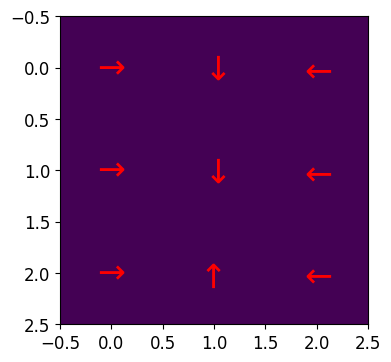

In [201]:
# np.array([[1,2,1],[1,5,1],[1,3,1]])
policy = SoftmaxPolicy(3, 4)
policy = MinMaxOracle(env, policy, np.array([[1,2,1],
                                                 [1,5,1],
                                                 [1,3,1]]), 0, T=20, K=20, b=1/4, lr_factor=1, lamb_boost=1)

In [202]:
p = policy
alpha = [1]
C = [policy]
mix_p = MixturePolicy(alpha, C)
res = DensityOracle(env, mix_p, 0,0.1, M=50, t0=100)
res

50 100


array([[0.10799968, 0.13800048, 0.16199952],
       [0.07199979, 0.04600122, 0.08999973],
       [0.07199979, 0.25799995, 0.05399984]])

In [203]:
eps=5
sigma = 0.1*eps / (2*env.S)
eps0 = 0.1*eps**2/(80*env.S)
eps1 = 0.1*eps
eta = 0.1*eps**2/(40*env.S)
T= 40*env.S*np.log(np.log(env.S)/(0.1*eps))/(0.1*eps**2)

smoothed_max_ent = lambda d: np.sum(-np.log(d+sigma))
smoothed_max_ent_dR = lambda d: -(d/(d+sigma)+np.log(d+sigma))

In [11]:
gamma = 0.9
delta = 0.05
M = int(200/(eps0**2) * np.log(2*env.S*np.log(0.1*eps)/(delta*np.log(gamma))))
t0 = int(np.log(0.1*eps0)/np.log(gamma))
M, t0, sigma, eps0, eps1, eta, T

(128894286,
 75,
 0.027777777777777776,
 0.003472222222222222,
 0.5,
 0.006944444444444444,
 213.16927517806894)

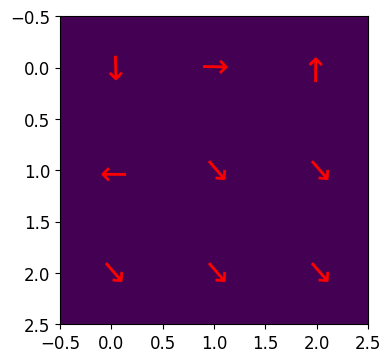

1000 100
Rewards: 
 [[0.14004159 0.131652   0.10673105]
 [0.12682568 0.12687819 0.10224596]
 [0.09949427 0.09361711 0.07251416]]


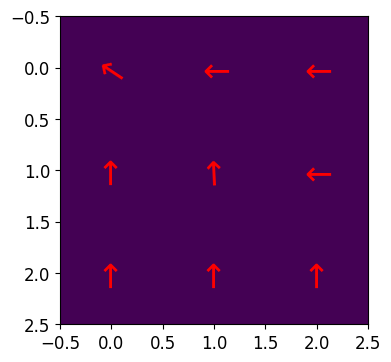

1000 100
Rewards: 
 [[0.13862077 0.13239236 0.10878089]
 [0.1237039  0.12325178 0.10608017]
 [0.10662814 0.09117719 0.06936479]]


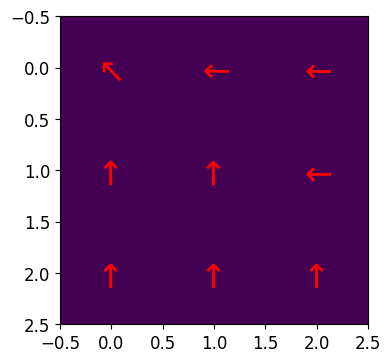

1000 100
Rewards: 
 [[0.12424412 0.12173199 0.10396868]
 [0.12985727 0.12484861 0.09977583]
 [0.11318101 0.10604074 0.07635175]]


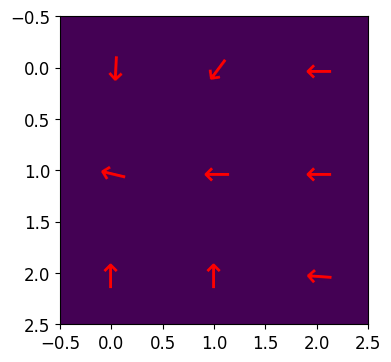

1000 100
Rewards: 
 [[0.13445339 0.12770067 0.09963695]
 [0.12695838 0.12995259 0.10102303]
 [0.11013059 0.10046206 0.06968235]]


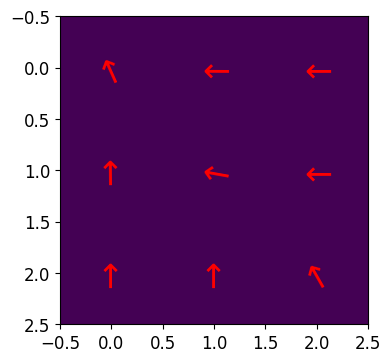

1000 100
Rewards: 
 [[0.13248852 0.12941327 0.0976338 ]
 [0.12847489 0.13038273 0.10266368]
 [0.10783037 0.09948055 0.07163218]]


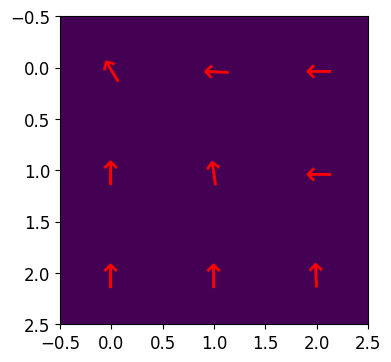

1000 100
Rewards: 
 [[0.11732589 0.13095609 0.11141168]
 [0.12639284 0.12523328 0.10329732]
 [0.1150491  0.09898486 0.07134895]]


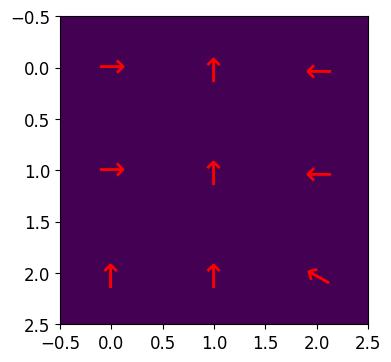

1000 100
Rewards: 
 [[0.11385377 0.13349967 0.10968662]
 [0.11941071 0.12855755 0.10628918]
 [0.10526813 0.10280532 0.08062905]]


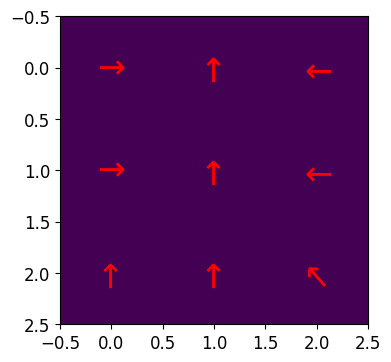

1000 100
Rewards: 
 [[0.12016547 0.12086934 0.10215236]
 [0.12263482 0.1302653  0.10627348]
 [0.1135609  0.10679501 0.07728332]]


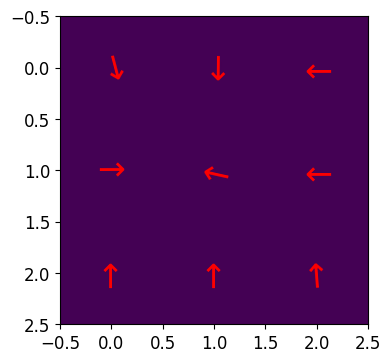

1000 100


KeyboardInterrupt: 

In [12]:
mix_policy = algorithm1(env, smoothed_max_ent_dR, eps=eps, eta=1e-2, eps0=eps0, eps1=eps1, T=200, Tmm=20, K=20)

In [13]:
res = DensityOracle(env, mix_policy, 0, 0.1, M=5000, t0=100)
res

NameError: name 'mix_policy' is not defined

### Old stuff

In [ ]:
p = Policy(9, 4)
p.distribution = np.array([[0.9, 0.05, 0.03, 0.02],
                           [0.05, 0.9, 0.03, 0.02],
                           [0.05, 0.03, 0.9, 0.02],
                           [0.02, 0.05, 0.03, 0.9],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025],
                           [0.5, 0.45, 0.025, 0.025]])

In [271]:
policy = DirectParamPolicy(3, 4)
policy.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
policy.updateDistribution()
env = gym.make('gym_examples/GridWorld-v3', render_mode="human", size=3, rewards=np.array([[1,2,3],[4,5,6],[7,8,9]]), costs=np.array([[1,2,3],[4,5,6],[7,8,9]]))

In [273]:
import time
observation, info = env.reset()
print((observation['agent'][0], observation['agent'][1]))
action = policy((observation['agent'][0], observation['agent'][1]))
print(action)
for _ in range(100):
    time.sleep(10)
    observation, reward_cost, terminated, truncated, info = env.step(action)
    print(observation)
    print(reward_cost)
    action = policy((observation['agent'][0], observation['agent'][1]))

    if terminated or truncated:
        observation, info = env.reset()

env.close()

(0, 0)
0


/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


{'agent': array([1, 0])}
[4, 4]
{'agent': array([1, 0])}
[4, 4]
{'agent': array([1, 0])}
[4, 4]
{'agent': array([1, 1])}
[5, 5]
{'agent': array([0, 1])}
[2, 2]
{'agent': array([0, 2])}
[3, 3]
{'agent': array([1, 2])}
[6, 6]
{'agent': array([1, 2])}
[6, 6]


KeyboardInterrupt: 

In [ ]:
#max_ent_R = lambda d: -np.sum(d * np.log(d))
max_ent_dR = lambda d: -(np.log(d)+1)

In [ ]:
#env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
#                  rewards=np.array([[1,2,3],[4,5,6],[7,8,9]])/45, costs=np.array([[1,1,1],[1,1,1],[1,1,1]])/9)
env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
                  rewards=np.array([[1,2,3],[4,5,6],[7,8,9]])/49, costs=np.array([[1,0,0],[0,0,0],[0,0,0]]))

In [ ]:
p = policy
p.updateDistribution()
p.distribution, p.params, np.argmax(p.distribution, axis=1)

## Parametric state action distribution estimation

In [363]:
import os
import torch
from torch import nn
import numpy as np
from tqdm import tqdm

In [364]:
size_S = 3**2
size_A = 4
dim_S = 3

model = nn.Sequential(
          nn.Linear(size_S + size_A, size_S * size_A),
          nn.ReLU(),
          nn.Linear(size_S * size_A,size_S * size_A),
          nn.ReLU(),
          nn.Linear(size_S * size_A,size_S * size_A),
          nn.Softmax(dim=0)
        )

'''
    oneHot:
    stateNext & actionNext: actions and states of which density should be evaluated
    dim_S: size of the square (3) for 3x3 grid
    size_A: size of the action space
'''
def oneHot(stateNext, actionNext, dim_S, size_A):
    input = torch.zeros([dim_S**2 + size_A], requires_grad=False)
    input[dim_S * stateNext[0] + stateNext[1]] = 1
    input[size_S + actionNext] = 1
    return input

'''
    stateAction_to_state:
    Finds the state occupancy measure given the stateAction occupancy measures
'''
def stateAction_to_state(stateAction):
  state = torch.zeros([size_S])
  for s in range(0,size_S):
    for a in range(0,size_A):
      state[s] += stateAction[s + a * size_S]
  return state


In [365]:
env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
                  rewards=np.array([[1,2,3],[4,5,6],[7,8,9]])/49, costs=np.array([[1,0,0],[0,0,0],[0,0,0]]))

In [366]:
#Initialise parameters
rho0 = np.ones((dim_S,dim_S))/size_S   #Initial state distribution
policy = Policy(9, 4)                  #Uniform policy
policyParam = 1/4
numIterations = 5000000                    #Number of iterations
eta = 1e-6
gamma = 0.999
correct = torch.ones([size_S])/size_S

#Sample initial state and initial action
state = env.reset()[0]['agent']
action = policy((state[0], state[1]))
input = oneHot(state, action, dim_S, size_A)
stateAction = model.forward(input)

for t in tqdm(range(0,numIterations)):
    
    stateNext = env.step(action)[0]['agent']
    actionNext = policy((stateNext[0], stateNext[1]))

    input = oneHot(stateNext, actionNext, dim_S, size_A)
    stateActionNext = model.forward(input)

    id_stateAction = (1 + action)*(dim_S * state[0] + state[1])
    id_stateActionNext = (1 + actionNext)*(dim_S * stateNext[0] + stateNext[1])

    tdError = rho0[state[0], state[1]] * policyParam + \
        gamma * stateAction[id_stateAction].item() - stateActionNext[id_stateActionNext].item()
    
    stateActionNext[id_stateActionNext].backward()
    if t % 500000 == 0:
        state_dist = stateAction_to_state(stateActionNext)
        print(state_dist)
        print(torch.norm(state_dist - correct))

    with torch.no_grad():
        for param in model.parameters():
            paramNext = param + eta * tdError * param.grad
            param.copy_(paramNext)
    
    with torch.no_grad():
        stateAction = stateActionNext
        state = stateNext
        action = actionNext

  0%|          | 0/5000000 [00:00<?, ?it/s]/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(
  0%|          | 1739/5000000 [00:00<09:32, 8738.04it/s]

tensor([0.1040, 0.1049, 0.1133, 0.1258, 0.1086, 0.1054, 0.1072, 0.1323, 0.0983],
       grad_fn=<CopySlices>)
tensor(0.0313, grad_fn=<LinalgVectorNormBackward0>)


 10%|█         | 501877/5000000 [00:54<07:59, 9381.09it/s]

tensor([0.1042, 0.1048, 0.1131, 0.1259, 0.1085, 0.1054, 0.1076, 0.1322, 0.0982],
       grad_fn=<CopySlices>)
tensor(0.0312, grad_fn=<LinalgVectorNormBackward0>)


 13%|█▎        | 660440/5000000 [01:11<07:48, 9265.27it/s]


KeyboardInterrupt: 

In [352]:
P_pi = np.array([[0.5, 0.25, 0, 0.25, 0, 0, 0 ,0 , 0],
         [0.25, 0.25, 0.25, 0, 0.25, 0, 0, 0, 0],
         [0, 0.25 ,0.5, 0, 0, 0.25, 0, 0, 0],
         [0.25, 0, 0, 0.25, 0.25, 0, 0.25, 0, 0],
         [0, 0.25, 0, 0.25, 0, 0.25, 0, 0.25, 0],
         [0, 0, 0.25, 0, 0.25, 0.25, 0, 0, 0.25],
         [0, 0, 0, 0.25, 0, 0, 0.5, 0.25, 0],
         [0, 0, 0, 0, 0.25, 0, 0.25, 0.25, 0.25],
         [0, 0, 0, 0, 0, 0.25, 0, 0.25, 0.5]], float)
d_0 = np.ones(9)/9
I = np.identity(9)
d_stat = np.linalg.solve((I - gamma* P_pi), (1-gamma)*d_0)
d_stat

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [ ]:
d_0 = np.array([1,0,0,0,0,0,0,0,0])
for _ in range(0,100):
    d_stat = np.linalg.solve((I - gamma* P_pi), (1-gamma)*d_0)
    d_0 = d_stat
    if _%10==0:
        print(d_stat)

# Implementation of ReLOAD: RL with Oprimistic Ascent-Descent 
# for Last-Iterate Convergence in Constrained MDPs

In [112]:
import gym
import gym_examples
import numpy
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

## Plotting functions

In [122]:
'''
    _______PlotQ_______
    Q function plotting
'''
def PlotQ(A):
    actions = ['down', 'right', 'up', 'left']
    nrows, ncols, ntables = A.shape
    fig, axes = plt.subplots(ncols=ntables, figsize=(ntables*4, 4))
    
    norm = mcolors.Normalize(vmin=A.min(), vmax=A.max())
    cmap = plt.get_cmap('coolwarm')

    for i, ax in enumerate(axes):
        img = ax.imshow(A[:,:,i], cmap=cmap, norm=norm)
        ax.set_title(f'{actions[i]}')
        ax.set_xticks(range(ncols))
        ax.set_yticks(range(nrows))

        for x in range(ncols):
            for y in range(nrows):
                ax.text(y, x, f'{A[x, y, i]:.4g}', ha='center', va='center', color='k')

    plt.tight_layout()
    plt.show()

'''
    _______PlotV_______
    V function plotting
'''
def PlotV(A, B):
    weighted_average = np.sum(A * B, axis=2)
    
    nrows, ncols = weighted_average.shape
    fig, ax = plt.subplots(figsize=(4, 4))
    
    norm = mcolors.Normalize(vmin=weighted_average.min(), vmax=weighted_average.max())
    cmap = plt.get_cmap('coolwarm')

    img = ax.imshow(weighted_average, cmap=cmap, norm=norm)
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))

    for x in range(ncols):
        for y in range(nrows):
            ax.text(y, x, f'{weighted_average[x, y]:.4g}', ha='center', va='center', color='k')

    plt.tight_layout()
    plt.show()


'''
    _______PlotD_______
    D function plotting
'''
def PlotD(weighted_average, title):
    nrows, ncols = weighted_average.shape
    fig, ax = plt.subplots(figsize=(4, 4))
    
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.get_cmap('coolwarm')

    img = ax.imshow(weighted_average, cmap=cmap, norm=norm)
    ax.set_xticks(range(ncols))
    ax.set_yticks(range(nrows))
    ax.set_title(title)

    for x in range(ncols):
        for y in range(nrows):
            ax.text(y, x, f'{weighted_average[x, y]:.4g}', ha='center', va='center', color='k')

    plt.tight_layout()
    plt.show()

'''
    _______PlotPOLICY_______
    Q function plotting
'''
def PlotPolicy(A):
    actions = ['down', 'right', 'up', 'left']
    nrows, ncols, ntables = A.shape
    fig, axes = plt.subplots(ncols=ntables, figsize=(ntables*4, 4))
    
    norm = mcolors.Normalize(vmin=1, vmax=1)
    cmap = plt.get_cmap('coolwarm')

    for i, ax in enumerate(axes):
        img = ax.imshow(A[:,:,i], cmap=cmap, norm=norm)
        ax.set_title(f'{actions[i]}')
        ax.set_xticks(range(ncols))
        ax.set_yticks(range(nrows))

        for x in range(ncols):
            for y in range(nrows):
                ax.text(y, x, f'{A[x, y, i]:.4g}', ha='center', va='center', color='k')

    plt.tight_layout()
    plt.show()

## Policy and Policy Evaluation

In [276]:
'''
    _______DirectParamPolicy_______
    Same logic as for the other policies defined by Robert
    initially but for direct parametrization
'''
class DirectParamPolicy(Policy):
    def __init__(self, size, A, S=0):
        super().__init__(size, A, S)
        self.params = np.ones((self.size, self.size, self.A))
    
    
    def __call__(self, state):
        p = self.params[state]
        return np.random.choice(np.arange(self.A), p = p)
    
    # This is the same as also in the SoftmaxPolicy
    def plotPolicy(self):
        self.updateDistribution()
        plt.imshow(np.zeros((self.size, self.size)))
        for i in range(self.size):
            for j in range(self.size):
                angle = getAngle(self.distribution[i,j])
                plt.text(j, i, u'\u2192', ha="center", va="center", color="r", fontsize=24,
                        rotation=angle, rotation_mode='anchor')
    
    def updateDistribution(self):
        for i in range(self.size):
            for j in range(self.size):
                self.distribution[i,j] = self.params[i,j] / np.sum(self.params[i,j])


'''
    _____Mixture Policy_____
'''
# Have to "select" a policy at the start of each episode
class MixturePolicy():
    def __init__(self, alpha, C):
        self.alpha = alpha
        self.C = C
        self.activePolicy = None
        
    def selectPolicy(self):
        self.activePolicy = np.random.choice(self.C, p=self.alpha)   
        
    def __call__(self, state):
        return self.activePolicy(state)
    
    def plotPolicy(self):
        for pol in self.C:
            pol.plotPolicy()


'''
    _______Policy Evaluation_______
    env: the instantiation of the gridworld environment
    size_A: (int) size of the action space
    dim_S: (int) size of the square
    episodes: (int) number of episodes (in each episode the LR is adjusted)
    steps: (int) number of steps in the environment per epsiode
    policy: the corresponding policy
'''
def Policy_Evaluation(env, size_A, dim_S, episodes, steps, discount_factor, policy):

    #Initialise the Q-values
    Qr = np.zeros((dim_S, dim_S, size_A))
    Qc = np.zeros((dim_S, dim_S, size_A))
    c = 0

    Qr_LIST = []

    for episode in range(episodes):
        #Reseting the environment - get initial state and initial action
        state = env.reset()[0]['agent']
        action = policy((state[0], state[1]))

        #Set the learning rate
        learning_rate = 0.1

        Qr_LIST.append(Qr)

        for step in range(steps):

            #Step in environment
            observation, reward_cost, terminated, truncated, info = env.step(action)

            #Get new observation and new action
            new_state = observation['agent']
            new_action = policy((new_state[0], new_state[1]))

            Qr_toprint = np.copy(Qr)

            #Update the Q function values of the reward and constraint with SARSA
            Qr[state[0], state[1], action] = (1 - learning_rate) * Qr[state[0], state[1], action] + learning_rate * (reward_cost[0] + discount_factor * Qr[new_state[0], new_state[1], new_action])
            Qc[state[0], state[1], action] = (1 - learning_rate) * Qc[state[0], state[1], action] + learning_rate * (reward_cost[1] + discount_factor * Qc[new_state[0], new_state[1], new_action])

            #reset action
            action = new_action
            state = new_state
    
    return Qr, Qc, Qr_LIST

## Density Estimation

In [222]:
"""
    env: the CMDP environment
    policy: mixture policy to compute the state distribution of
    eps0: error tolerance
    M: number of episodes
    t0: number of time steps per episode
"""
def DensityMixEstimation(env, mix_policy, M=10, t0=1000):
    
    gamma = 0.9
    
    state_frequencies = np.zeros((M, env.size, env.size))
    
    
    for m in range(M):
        
        mix_policy.selectPolicy()
        observation = env.reset()[0]['agent']
        cur_gamma = 1
        
        for t in range(t0):
            
            action = mix_policy((observation[0], observation[1]))  # agent policy that uses the observation and info
            observation = env.step(action)[0]['agent']
            state_frequencies[m, observation[0], observation[1]] += cur_gamma
            cur_gamma *= gamma
            
    env.close()
    return np.sum(state_frequencies, axis=0)/M*(1-gamma)/(1-np.exp(np.log(gamma)*t0))



"""
    Estimates the density induced by a single policy
"""
def DensityEstimation(env, policy, M=10, t0=1000):
    
    gamma = 0.9
    
    state_frequencies = np.zeros((M, env.size, env.size))
    
    
    for m in range(M):
        
        observation = env.reset()[0]['agent']
        cur_gamma = 1
        
        for t in range(t0):
            
            action = policy((observation[0], observation[1]))  # agent policy that uses the observation and info
            observation = env.step(action)[0]['agent']
            state_frequencies[m, observation[0], observation[1]] += cur_gamma
            cur_gamma *= gamma
            
    env.close()
    return np.sum(state_frequencies, axis=0)/M*(1-gamma)/(1-np.exp(np.log(gamma)*t0))


'''
    From the state occupancy it calculates the state-action occupancy
'''
#State occupancy measure to state action occupancy measure:
def StateToStateAction(policy, d_s):

    numstates, numstates, numactions = policy.params.shape

    dsa = np.zeros((numstates, numstates, numactions))

    for i in range(numstates):
        for j in range(numstates):
            for k in range(numactions):
                dsa[i,j,k] = d_s[i,j] * policy.params[i,j,k]
    
    return dsa

'''
    From the state-action occupancy and policy it calculates the occupancy
'''
def StateActionToState(d_sa):
    d_s = np.sum(d_sa, axis = 2)
    return d_s

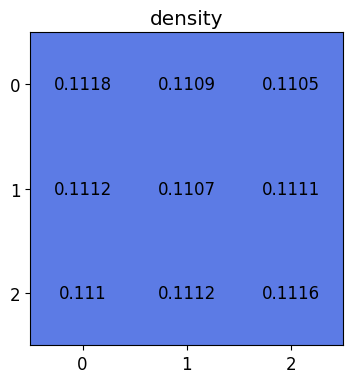

In [190]:
policy = DirectParamPolicy(3, 4)
policy.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
policy.updateDistribution()

env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,\
    rewards= np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]]), costs = np.array([[0,0,0],[0,0,0],[0,0,0]]))

D = DensityEstimation(env, policy, M=30000, t0=150)

PlotD(D, 'density')

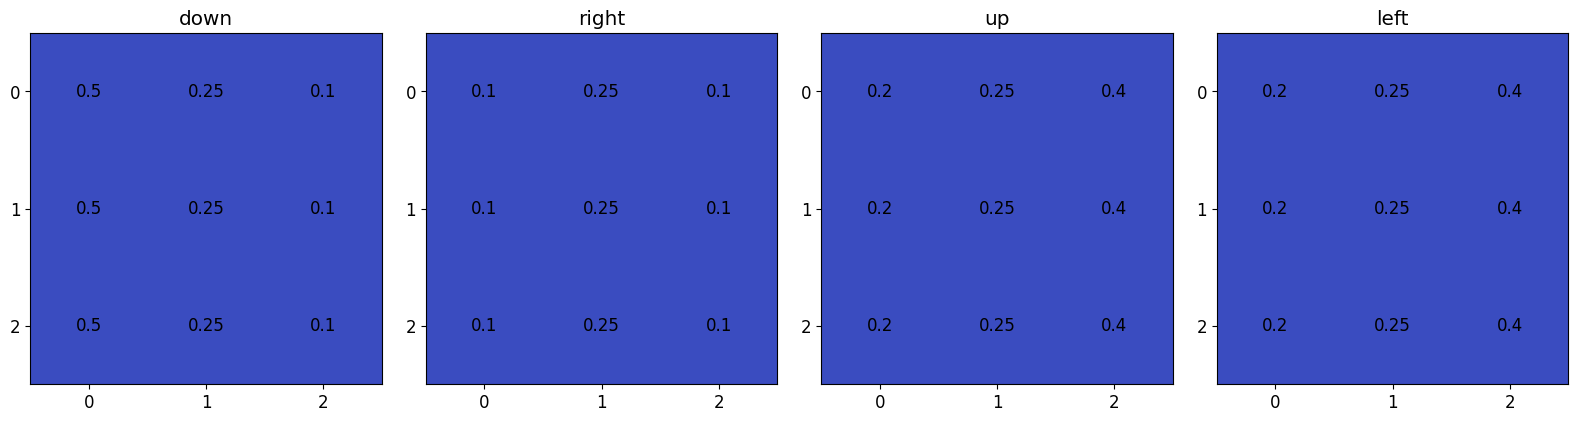

2
[0 2]
3
[0 1]
1
[0 2]
0
[1 2]
3
[1 1]


In [238]:
##Density Estimation test

M=1
t0 = 5

policy = DirectParamPolicy(env.size, env.A)
policy.params = np.array([
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]],
        
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]],
        
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]]
                        ])
policy.updateDistribution()
PlotPolicy(policy.params)

env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,\
    rewards= np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]]), costs = np.array([[0,0,0],[0,0,0],[0,0,0]]))
    


gamma = 0.9
    
state_frequencies = np.zeros((M, env.size, env.size))
    
    
for m in range(M):

    observation = env.reset()[0]['agent']
    cur_gamma = 1
    
    for t in range(t0):
            
        action = policy((observation[0], observation[1]))  # agent policy that uses the observation and info
        print(action)
        observation = env.step(action)[0]['agent']
        print(observation)
        state_frequencies[m, observation[0], observation[1]] += cur_gamma
        cur_gamma *= gamma

env.close()

## ReLOAD

In [267]:

'''
    _____ReLOAD____
    env:                pass the gridworld environment
    rho:                initial state distribution
    K:                  number of iterations of ReLOAD
    size_A:             size of the action space
    dim_S:              dimensionality of the state space
    train_episodes:     number of training episodes in the policy evaluation
    steps:              number of steps in policy evaluation
    discount_factor:    discount factor of the MDP
    policy:             initial policy
    policy0:            just also input initial policy
    threshold:          threshold for constraint violations
'''
#ReLOAD-MDPI
def ReLOAD(env, rho, K, size_A, dim_S, train_episodes, steps, discount_factor, policy, policy0, threshold):

    #Initialise the parameters
    mu0 = random.random()

    Qr, Qc, Qr_LIST = Policy_Evaluation(env, size_A, dim_S, train_episodes, steps, discount_factor, policy0)
    Qm = - Qr + mu0 * Qc

    Vc = np.sum(np.sum(Qc * policy.params, axis=2) * rho)

    #PlotQ(policy.params)
    #PlotQ(Qr)
    #PlotQ(Qc)

    mu = random.random()
    mu_list = []

    #_______COMMENT IN FOR TESTING_________
    Qr_params = []
    Qc_params = []
    policy_params = []

    for k in range(K):
        #Set the two learning rates
        eta_pi = 1/(k+20)
        eta_mu = 1/(k+20)

        #Evaluate new Q function, V function etc.
        Qr_new, Qc_new, Qr_list = Policy_Evaluation(env, size_A, dim_S, train_episodes, steps, discount_factor, policy)
        Qm_new = - Qr_new + mu * Qc_new
        Vc_new = np.sum(np.sum(Qc_new * policy.params, axis=2) * rho)
        
        old_params = np.copy(policy.params)

        #Update the policy
        for i in range(dim_S):
            for j in range(dim_S):
                log_term = (2 * Qm_new[i, j] - Qm[i, j]) / eta_pi
                max_log_term = np.max(log_term)
                exp_term = np.exp(log_term - max_log_term)

                policy.params[i, j] = (policy.params[i, j] * exp_term) / (np.sum(policy.params[i, j] * exp_term) + 1e-8)
                # Clip and normalize the probabilities
                policy.params[i, j] = np.clip(policy.params[i, j], 1e-8, 1)
                policy.params[i, j] /= (np.sum(policy.params[i, j]))
                
        policy.updateDistribution()

        #_______COMMENT IN FOR TESTING_________
        Qr_params.append(Qr)
        Qc_params.append(Qc)
        policy_params.append(old_params)

        #update lagrange multiplier
        mu = np.max(mu + eta_mu * (2 * Vc_new - Vc - threshold), 0)
        mu_list.append(mu)

        Qr = Qr_new
        Qc = Qc_new
        Qm = Qm_new
        Vc = Vc_new
    
    #_______COMMENT IN FOR TESTING_____

    return policy, Qr, Qc, mu_list, Qr_params, policy_params, Qc_params

## ReLOAD Testing

In [285]:
policy0 = DirectParamPolicy(5, 4)
policy0.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                           [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                           [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
print(policy0.params.shape)
policy0.updateDistribution()

policy0 = DirectParamPolicy(5, 4)
policy0.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                           [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
                           [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
print(policy0.params.shape)
policy0.updateDistribution()

#rewards = np.array([[0.8299,1.377,1.377],[1.125,1.601,1.276],[0.8554, 1.461, 0.9919]])
#constraints = np.array([[0,0,0],[0,0,0],[0,0,0]])
#rewards2 = np.array([[1,0,1],[0,0,0],[0,0,0]])/2
#constraints2 = np.array([[0,2,0],[0,2,0],[0,0,0]])/4

rewards = np.array([[10,0,0,0,0],
                    [0,0,0,0,0],
                    [2,0,0,0,0],
                    [0,0,0,0,1],
                    [0,0,0,0,0]])/13

print('rewards: ', rewards.shape)

constraints = np.array([[0,0,0,0,1],
                    [1,1,1,0,0],
                    [0,0,0,0,0],
                    [0,0,1,0,0],
                    [0,0,1,0,0]])/3

print('constraints: ', constraints.shape)

env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=5,
                  rewards= -rewards, costs = -constraints)

size_S = 5**2
size_A = 4
dim_S = 5

discount_factor = 0.90

learning_rate = 0.2

train_episodes = 15000
steps = 150
threshold = 0

rho = np.ones((5,5))/25
K = 20

policy, Qr, Qc, mu_list, Qr_params, policy_params, Qc_params = ReLOAD(env, rho, K, size_A, dim_S, train_episodes, steps, discount_factor, policy0, policy0, threshold)


(5, 5, 4)
(5, 5, 4)
rewards:  (5, 5)
constraints:  (5, 5)


/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/noahliniger/opt/miniconda3/envs/FORL/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


20 5 5 4


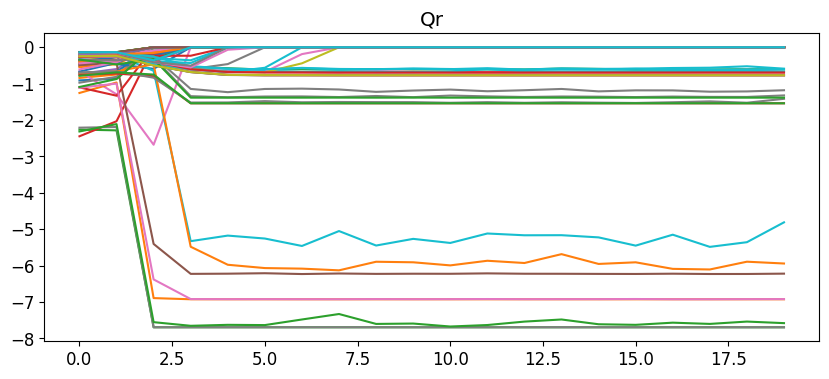

20 5 5 4


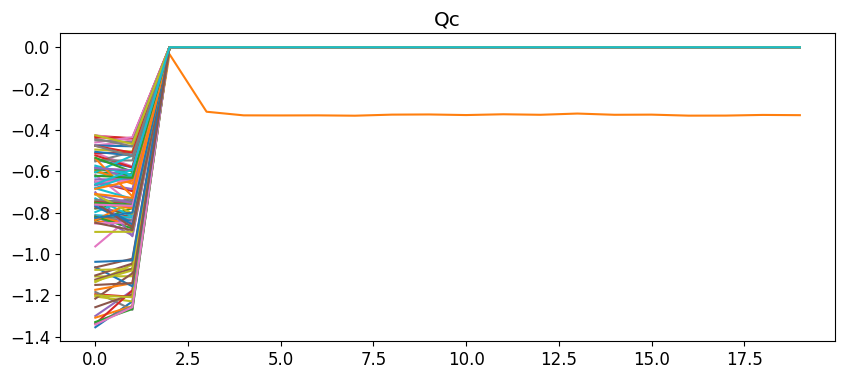

20 5 5 4


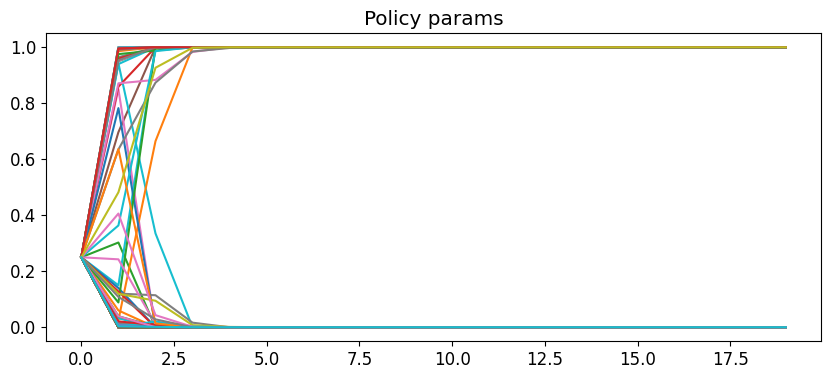

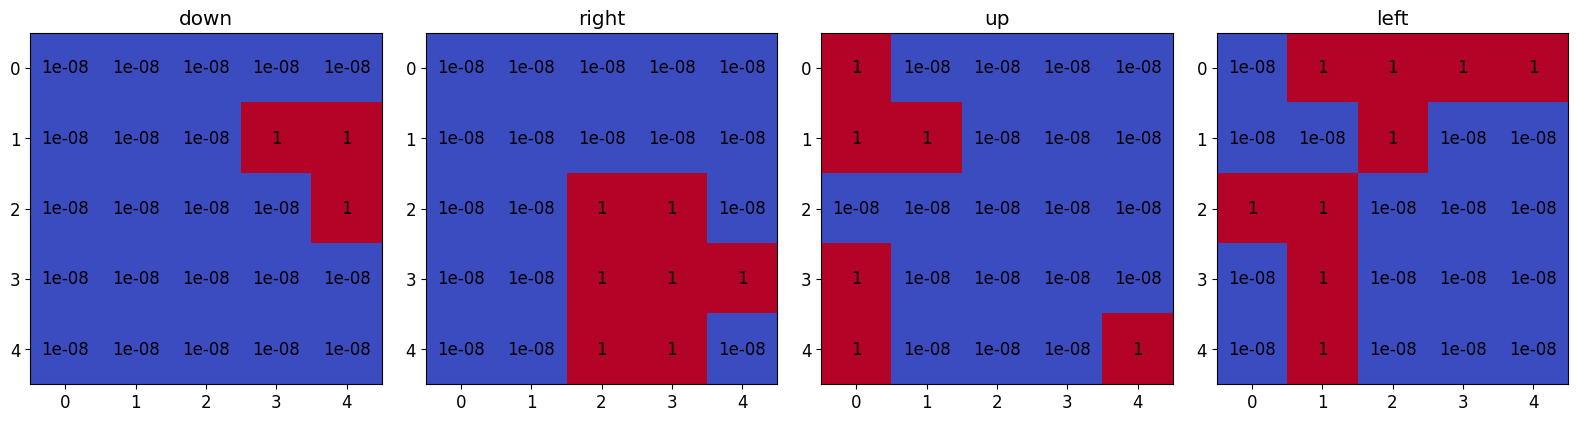

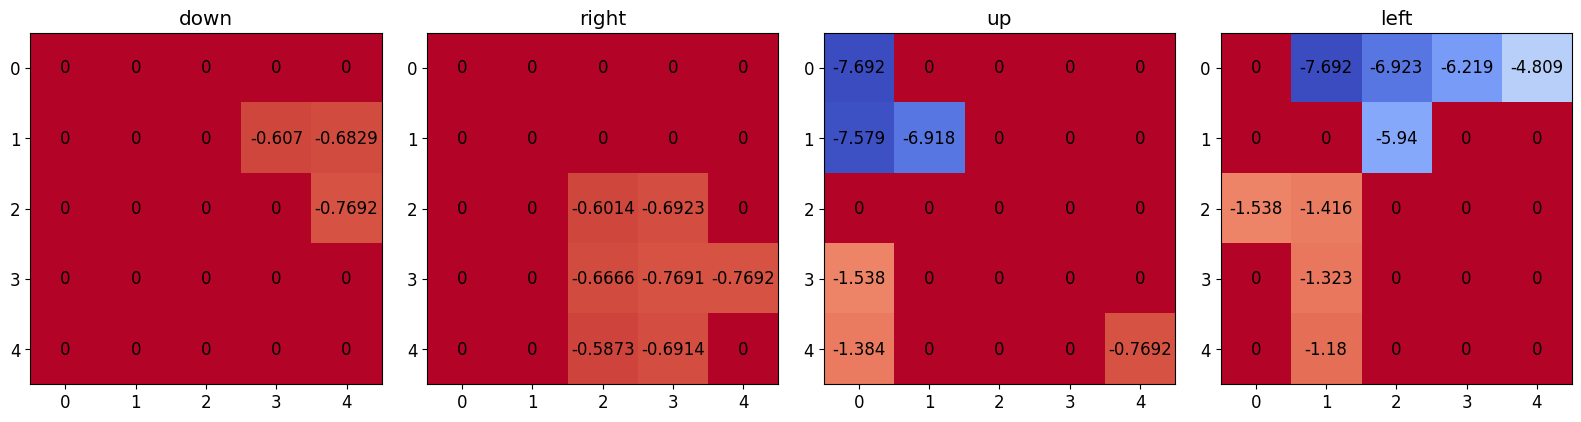

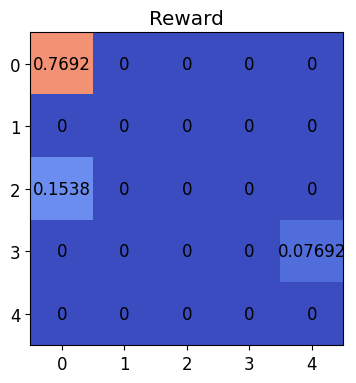

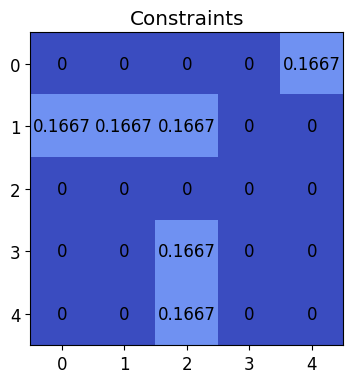

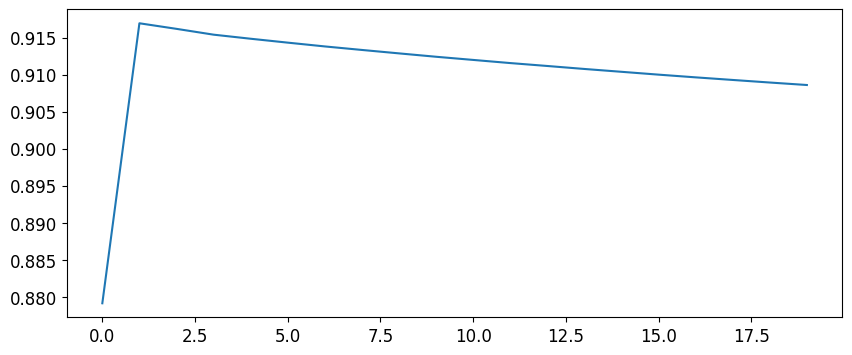

In [284]:
QR = np.array(Qr_params)
w, x, y, z = QR.shape
print(w, x, y, z)
for i in range(x):
    for j in range(y):
        for k in range(z):
            plt.plot(QR[:,i,j,k])
plt.title('Qr')
plt.show()

QC = np.array(Qc_params)
w, x, y, z = QC.shape
print(w, x, y, z)
for i in range(x):
    for j in range(y):
        for k in range(z):
            plt.plot(QC[:,i,j,k])
plt.title('Qc')
plt.show()

policy_params = np.array(policy_params)
w, x, y, z = policy_params.shape
print(w, x, y, z)
for i in range(x):
    for j in range(y):
        for k in range(z):
            plt.plot(policy_params[:,i,j,k])
plt.title('Policy params')
plt.show()

PlotQ(policy_params[-1])
plt.show()
PlotQ(QR[-1])
PlotD(rewards/np.sum(rewards), 'Reward')
PlotD(constraints/np.sum(constraints), 'Constraints')
plt.plot(mu_list)

## Frank Wolfe

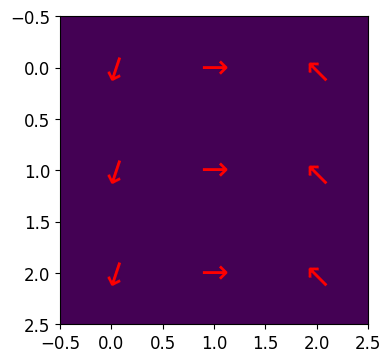

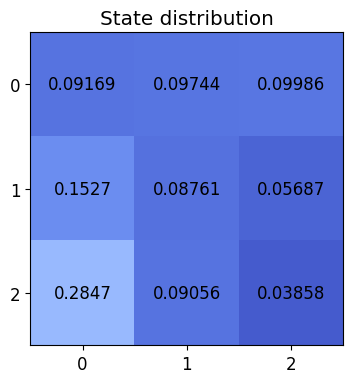

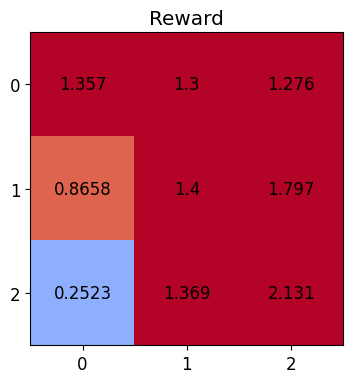

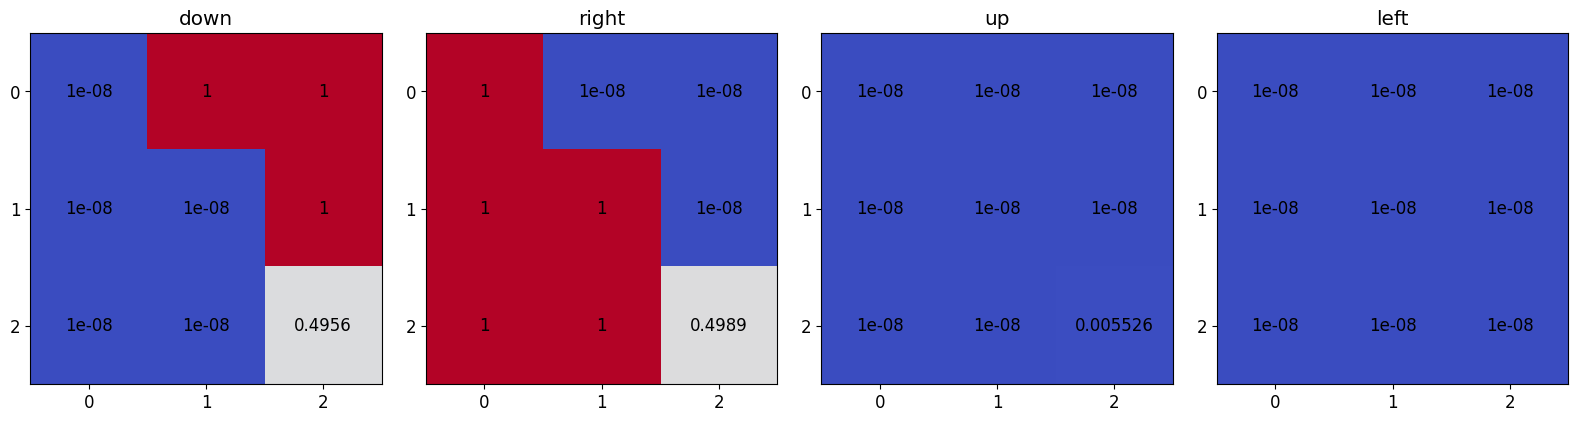

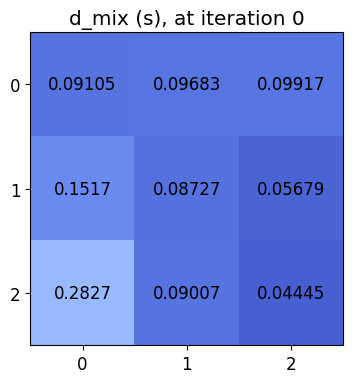

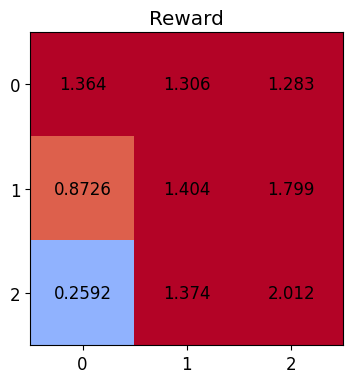

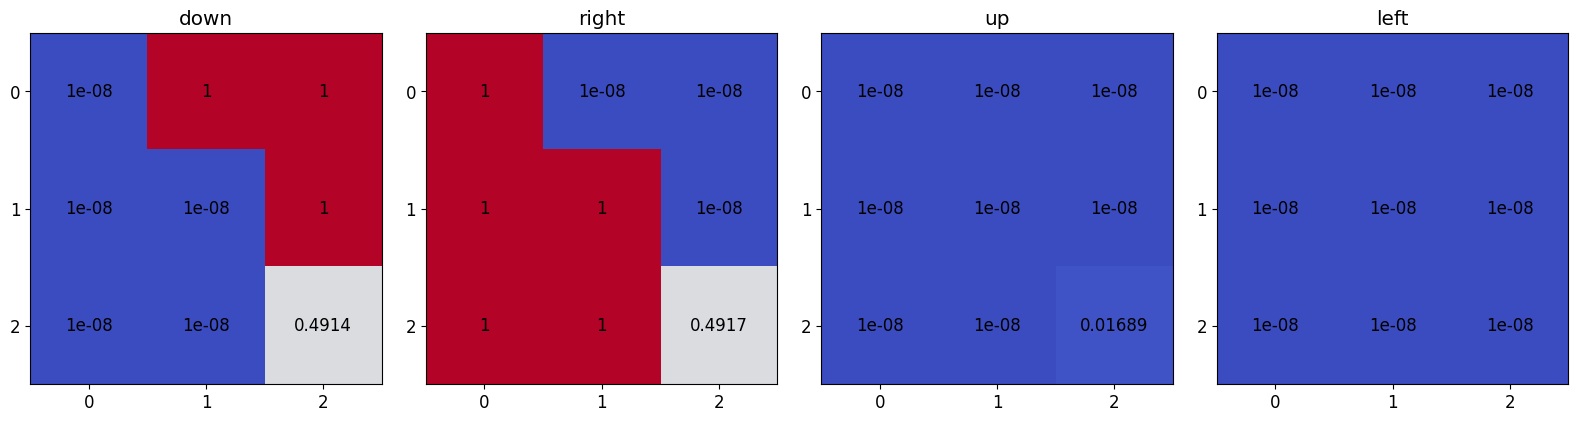

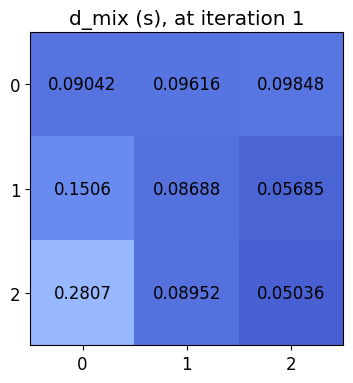

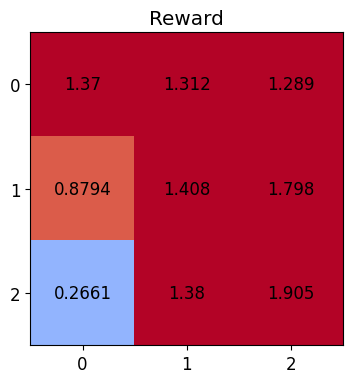

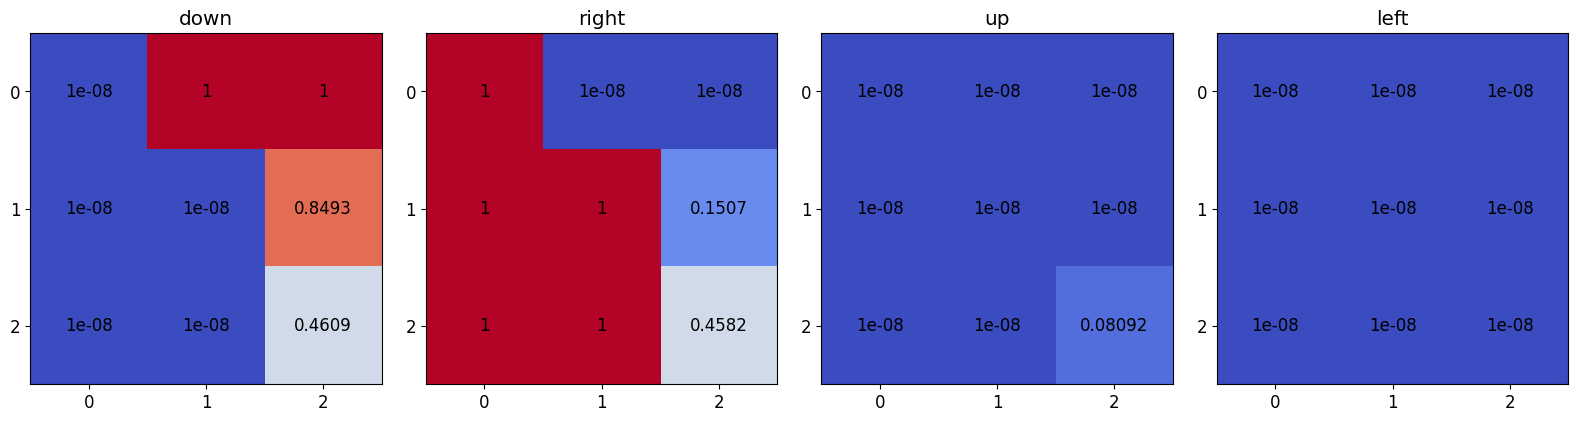

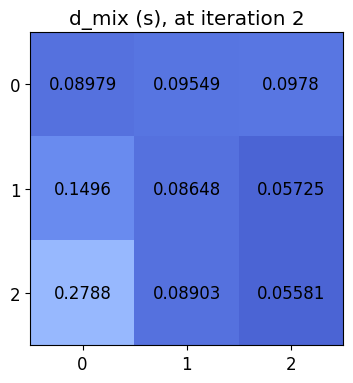

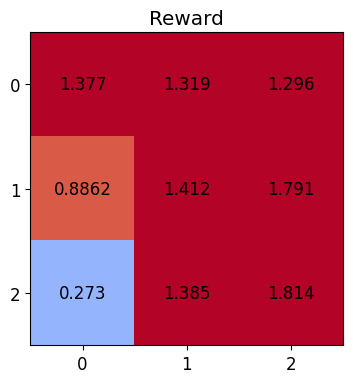

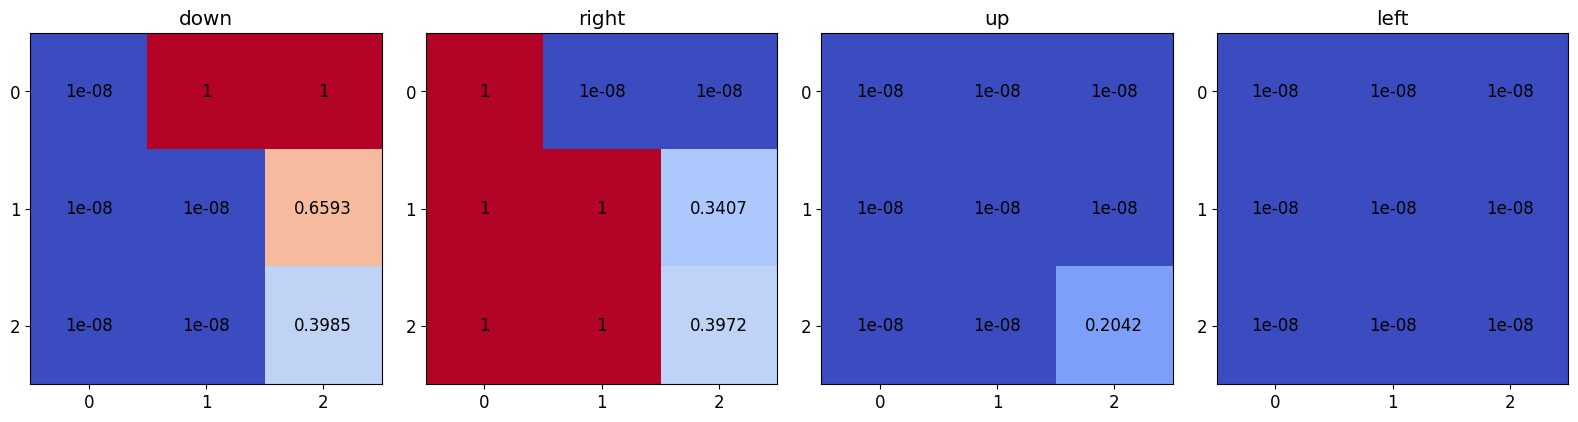

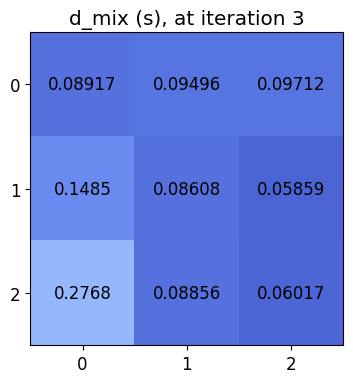

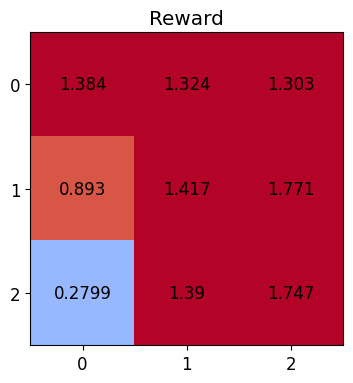

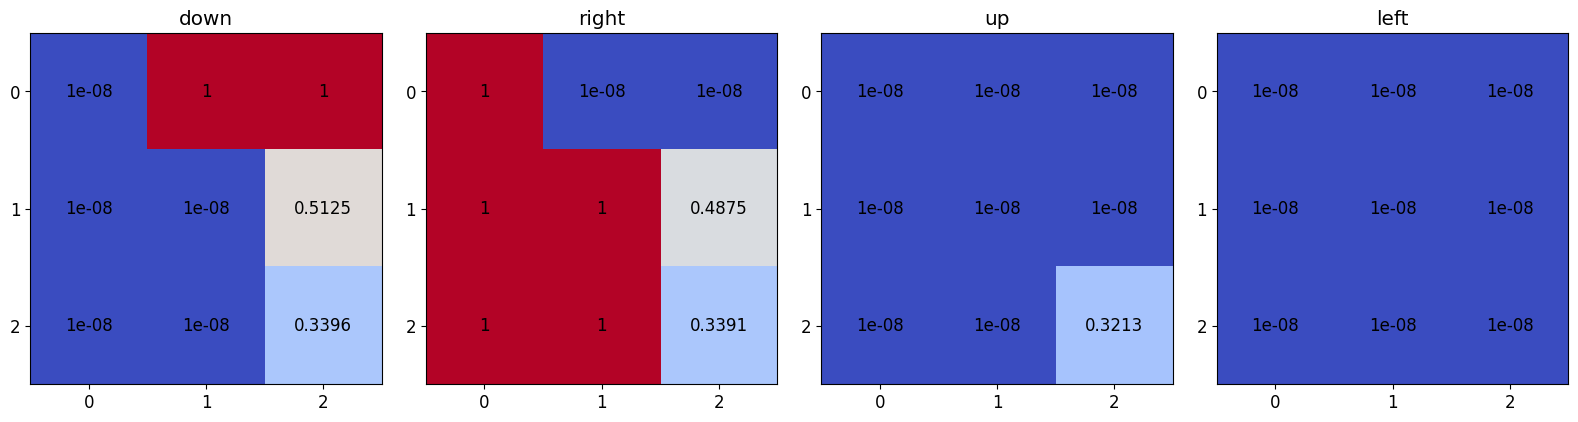

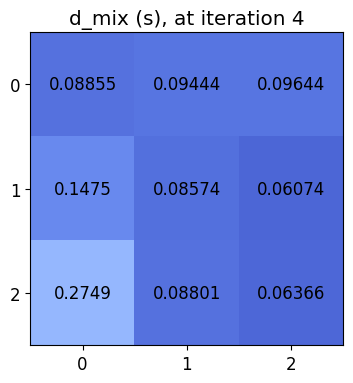

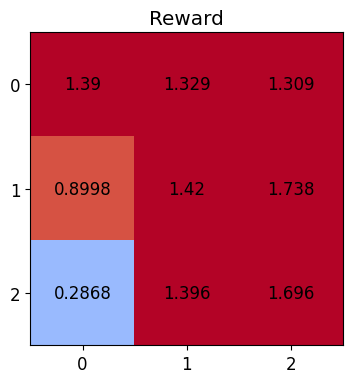

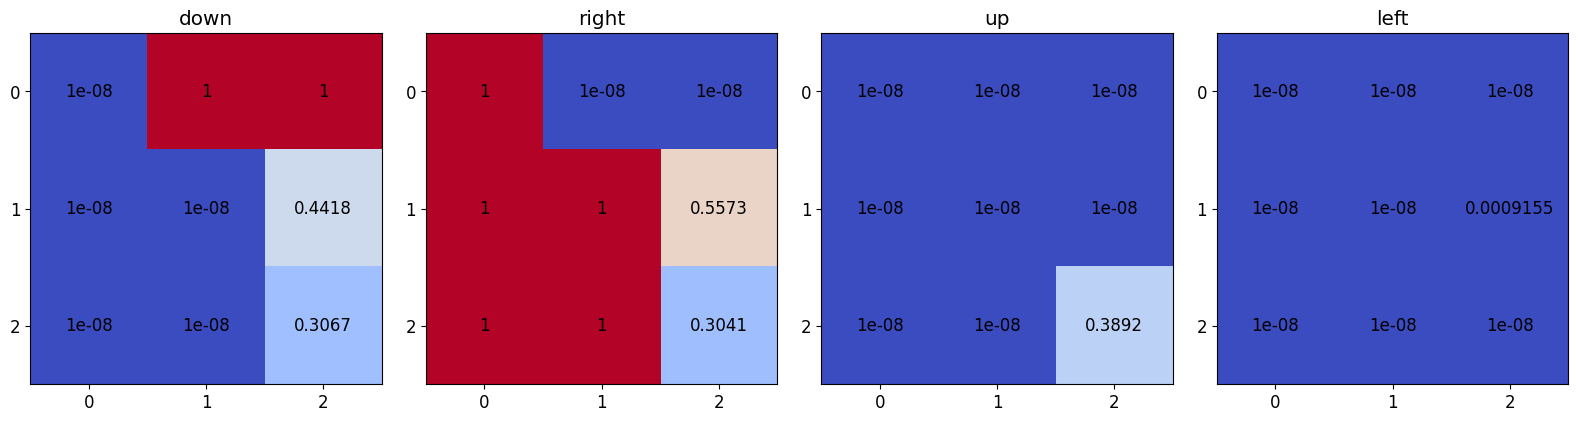

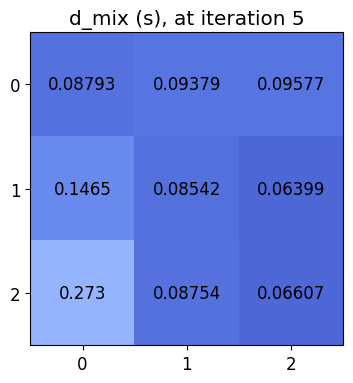

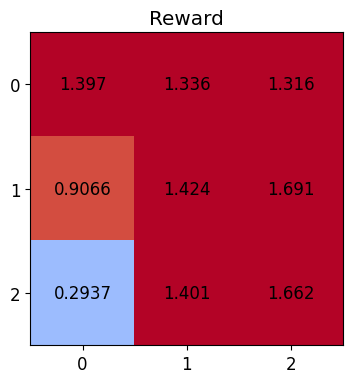

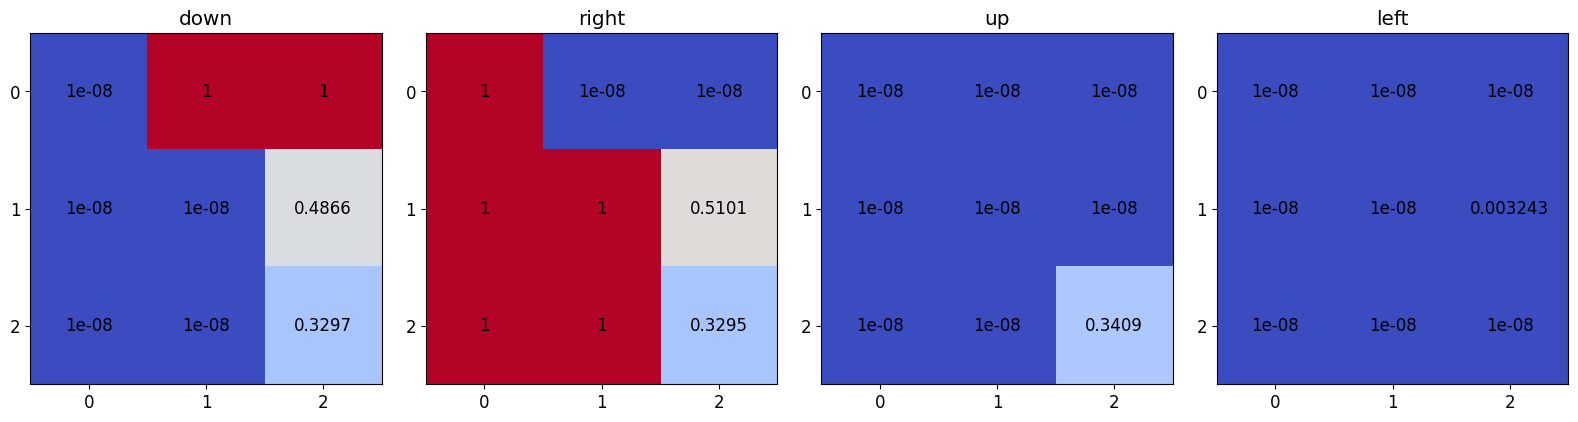

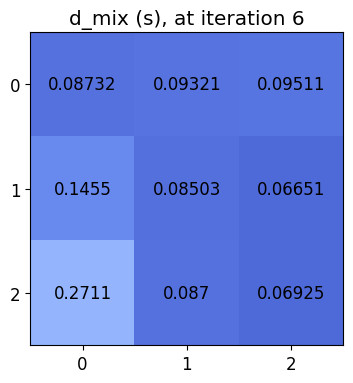

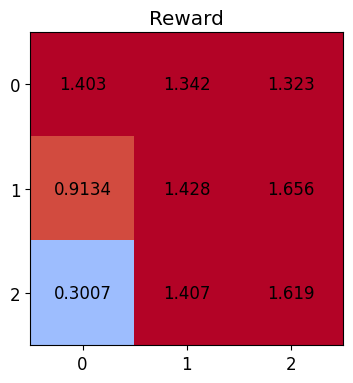

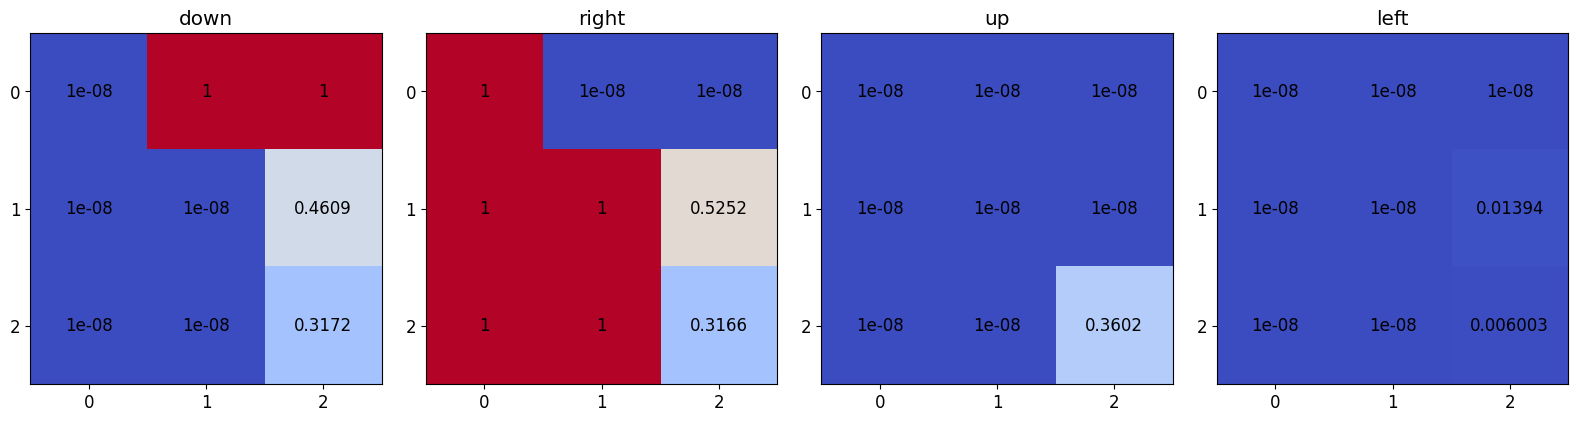

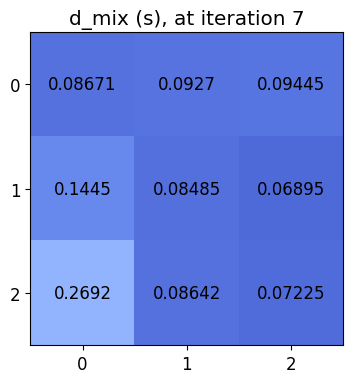

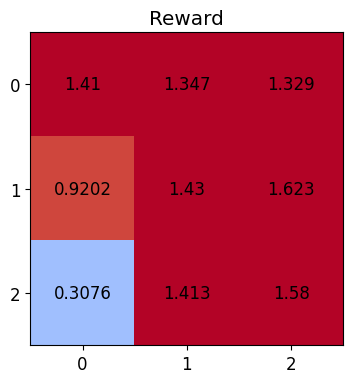

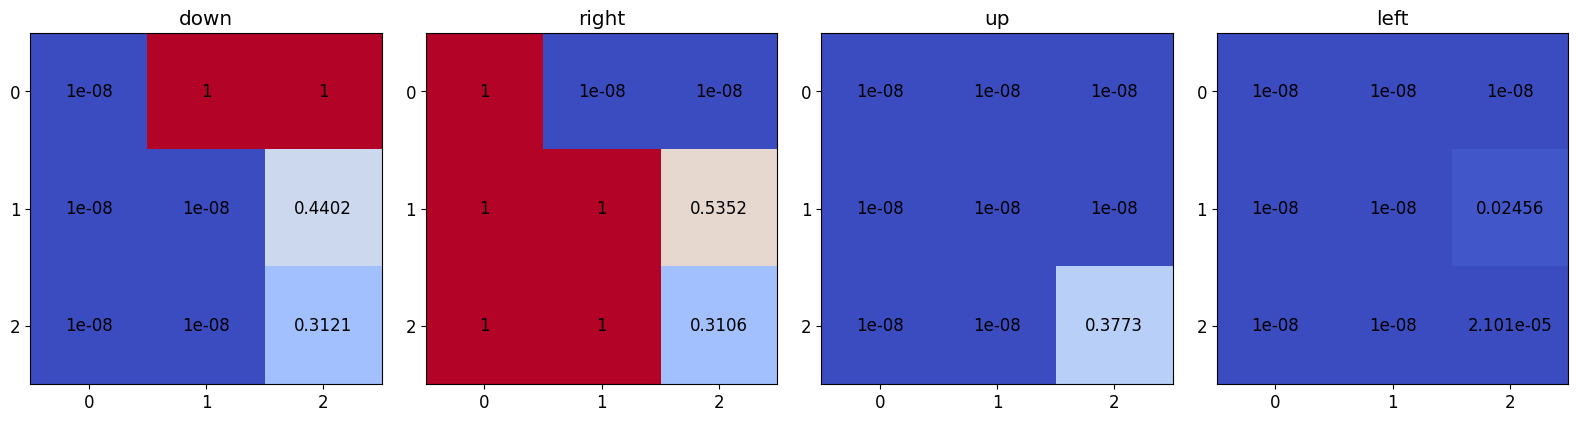

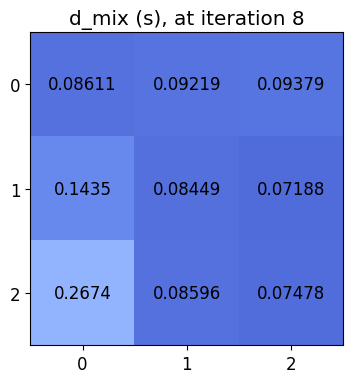

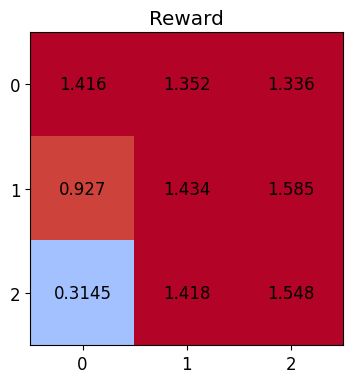

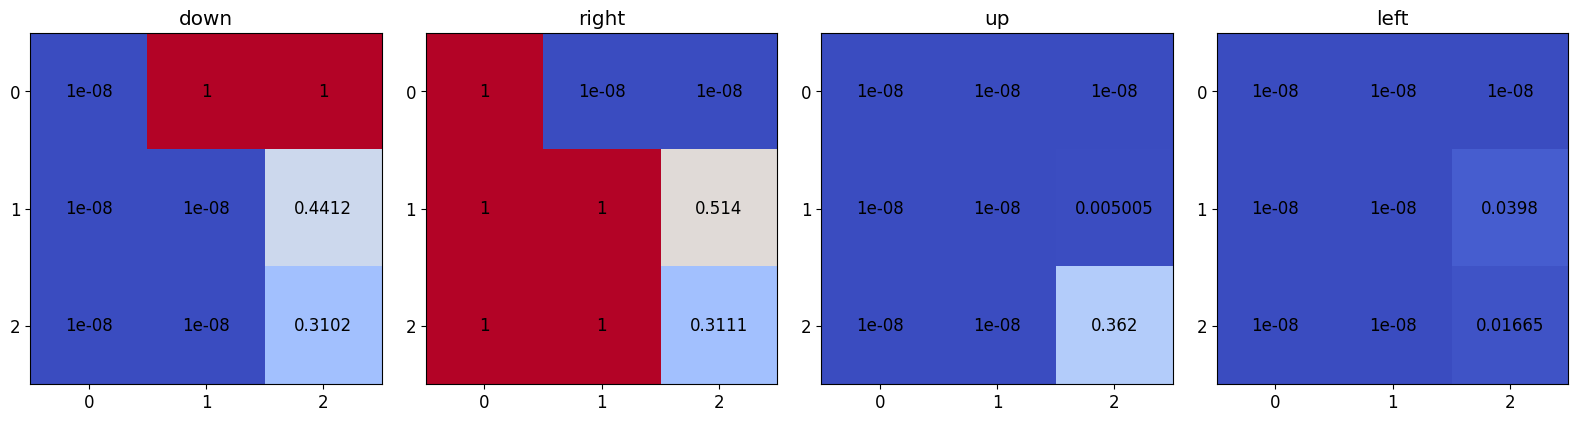

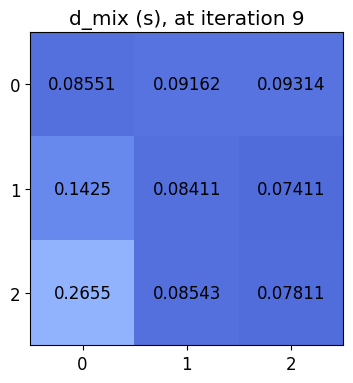

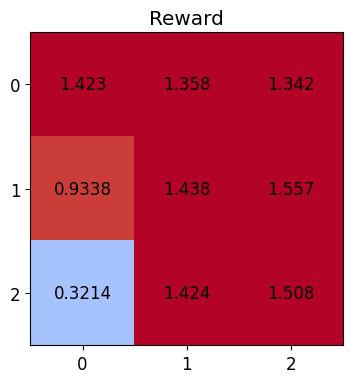

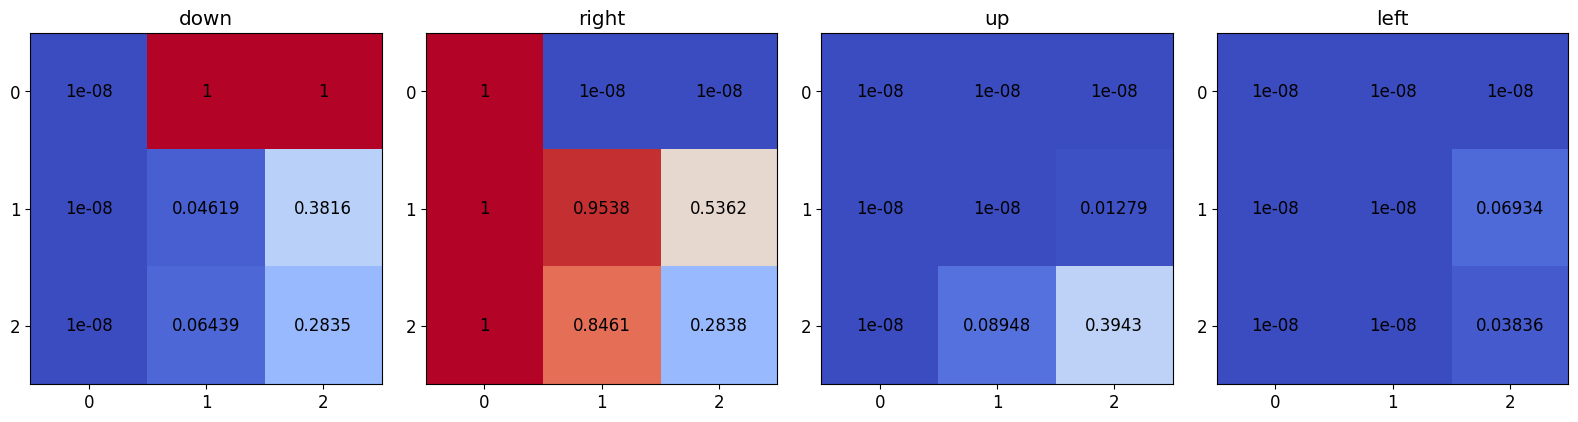

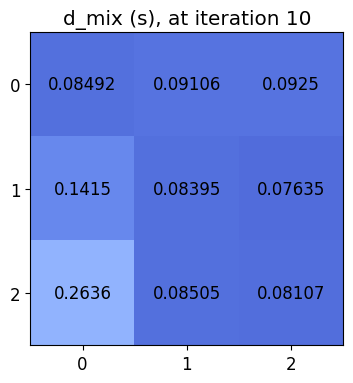

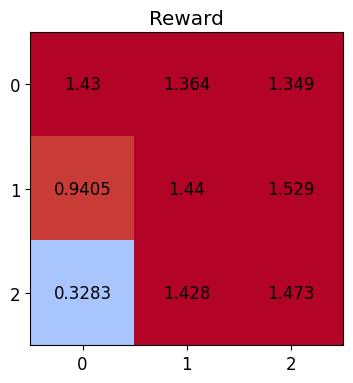

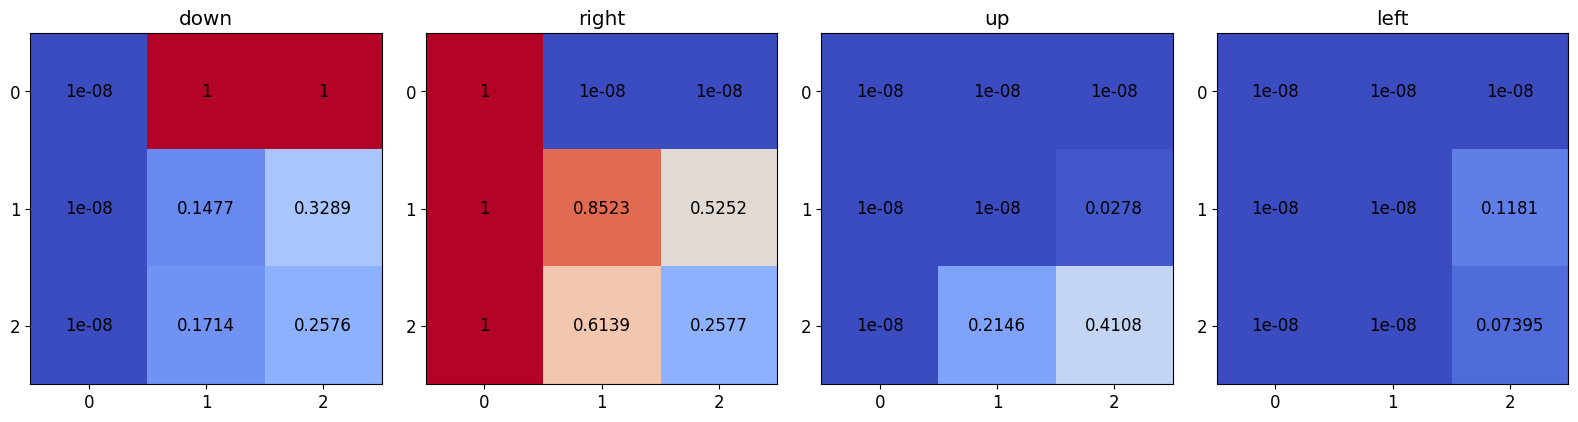

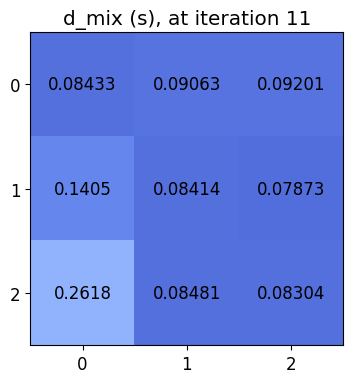

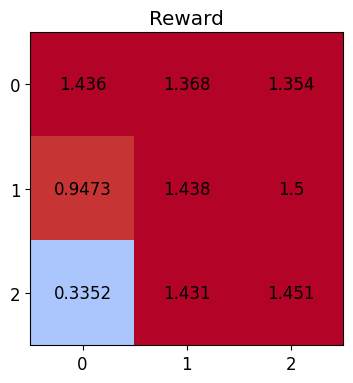

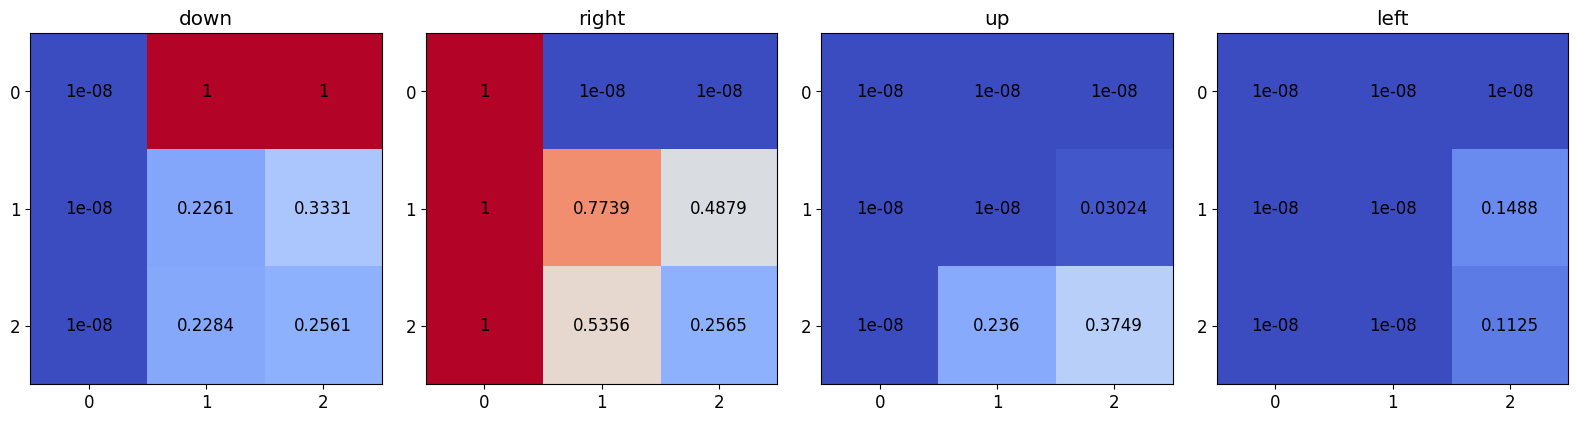

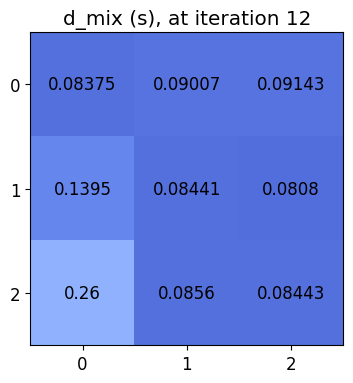

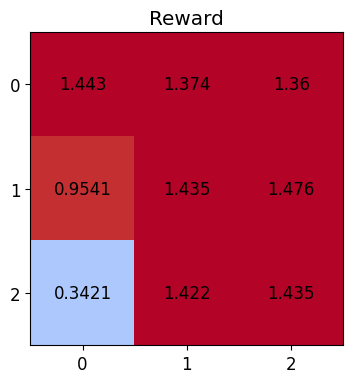

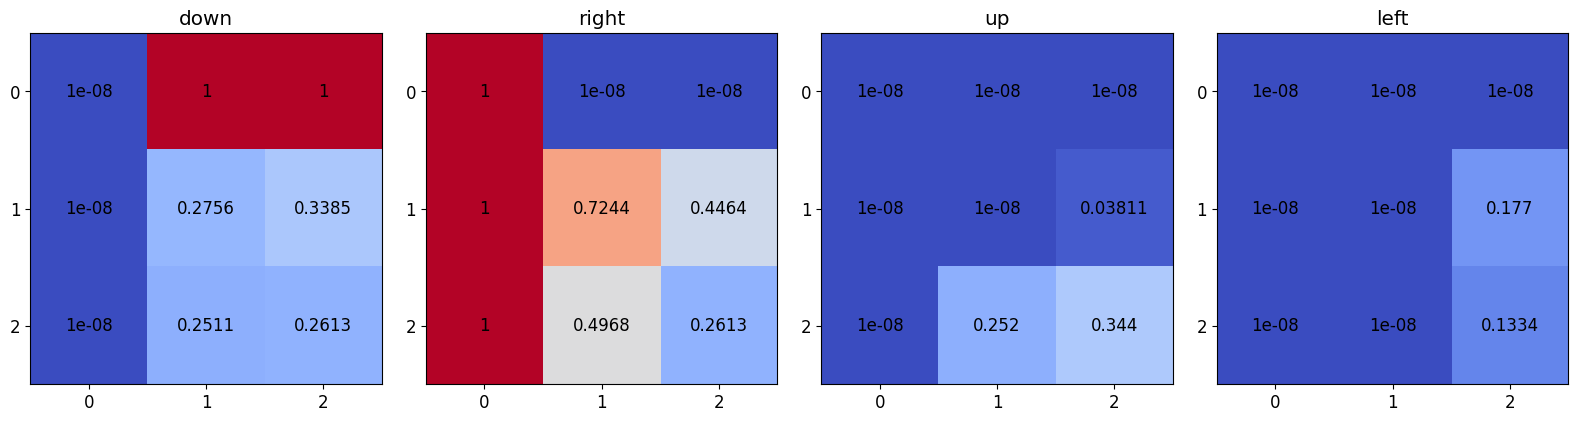

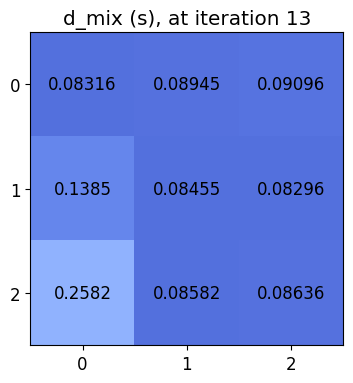

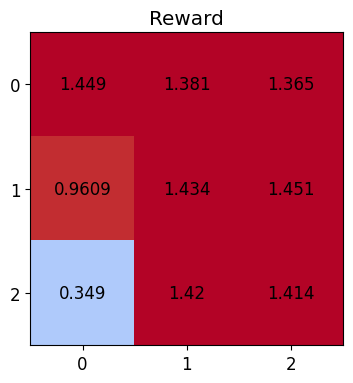

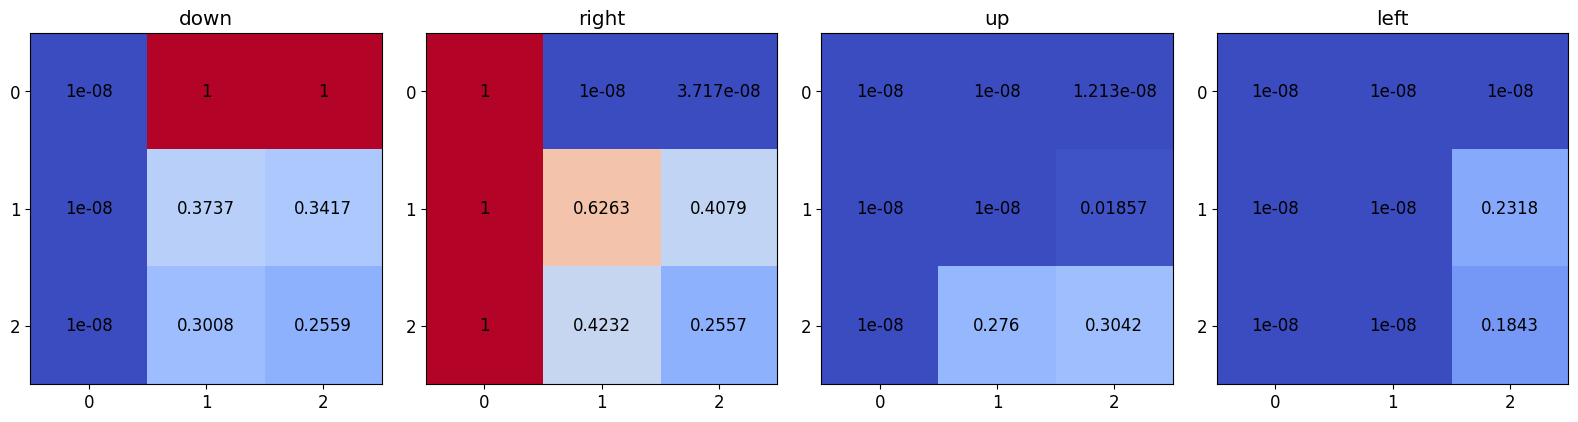

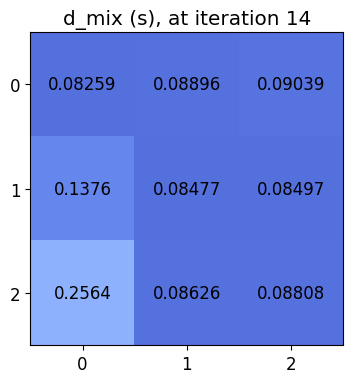

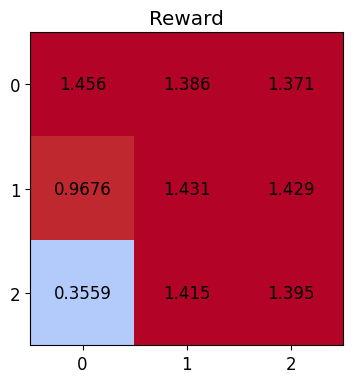

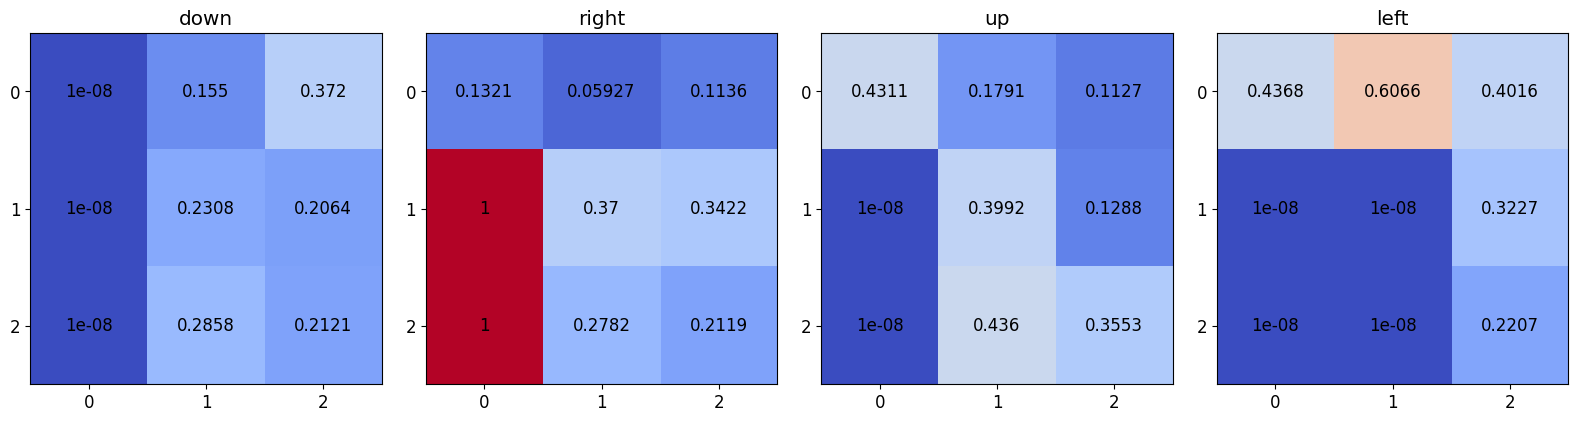

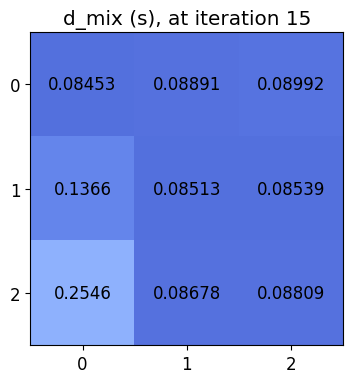

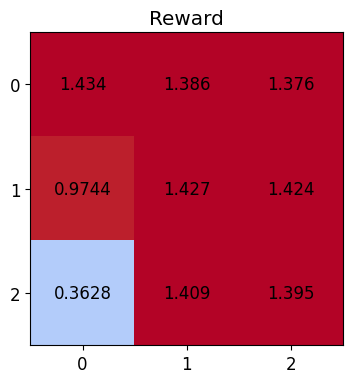

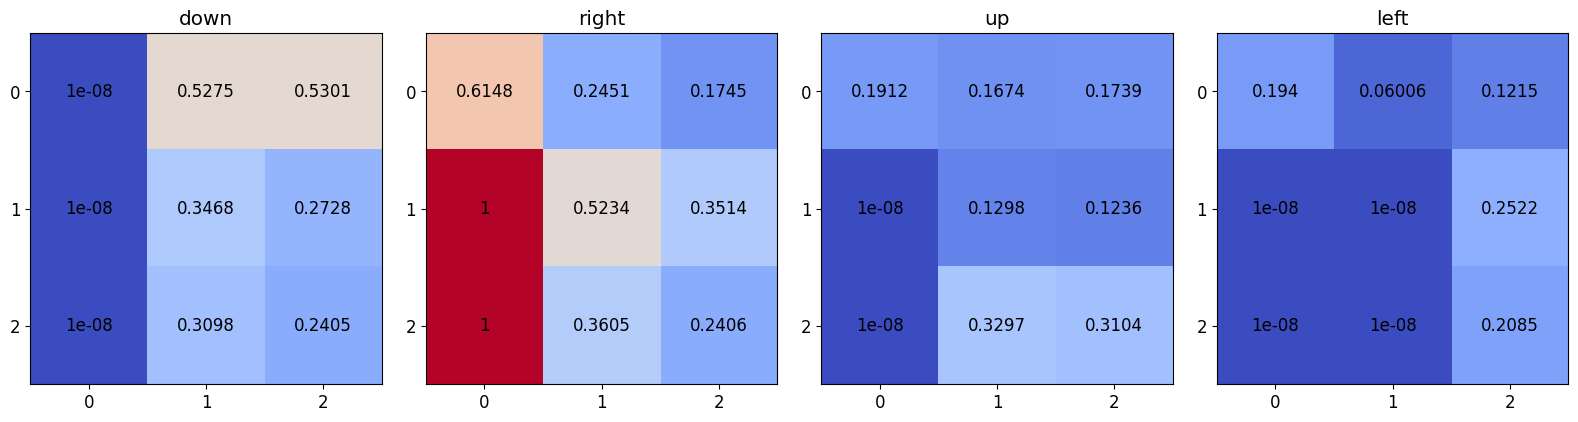

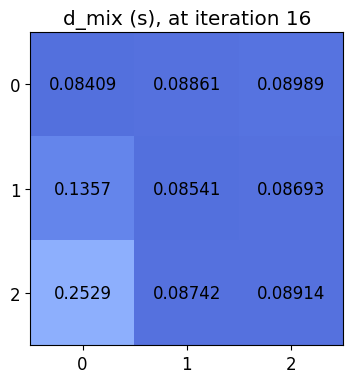

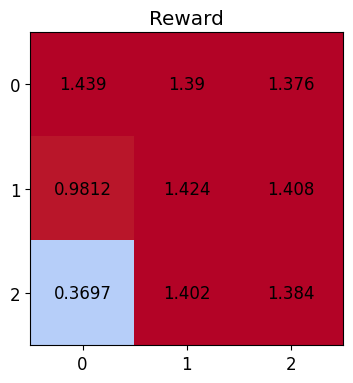

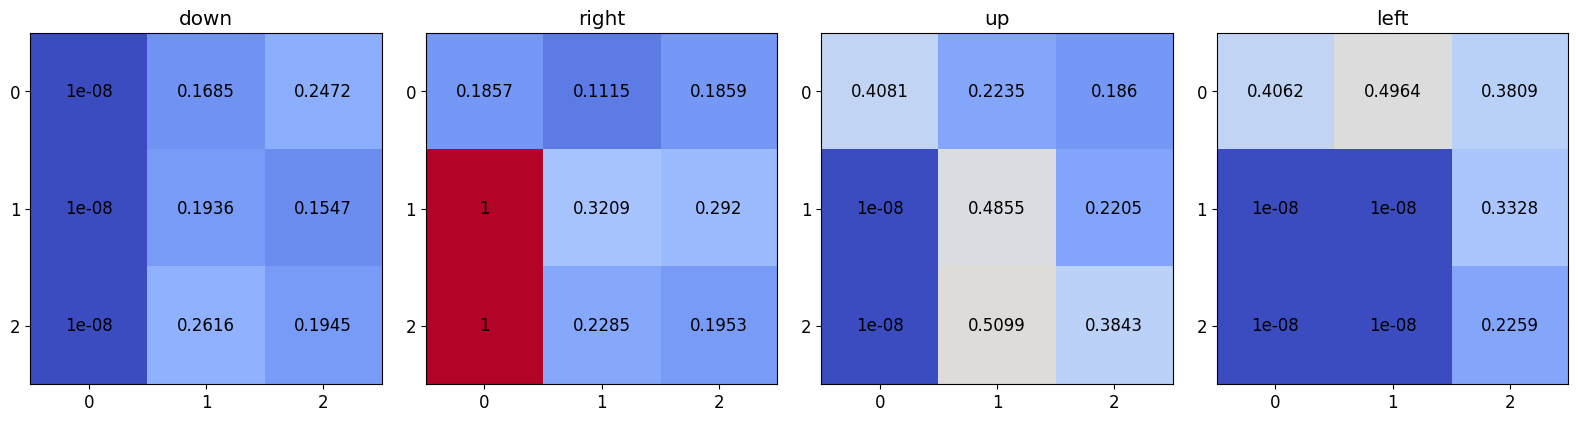

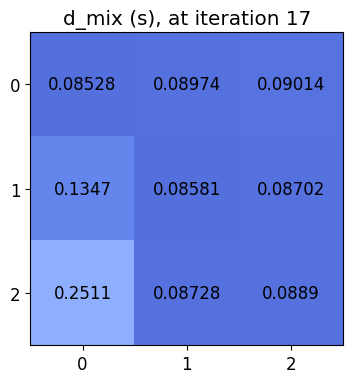

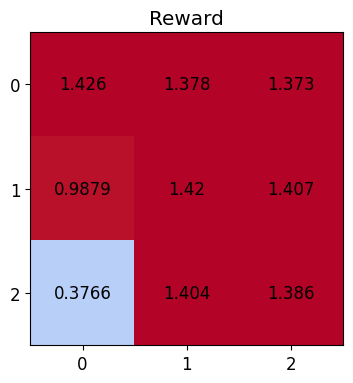

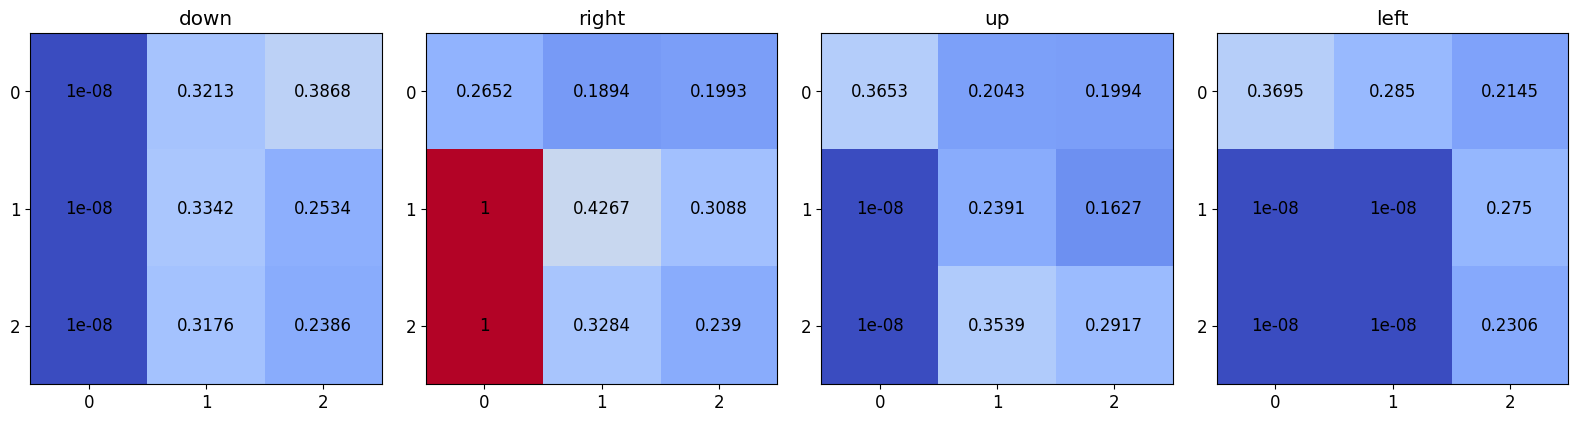

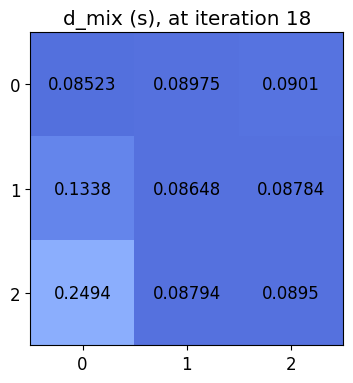

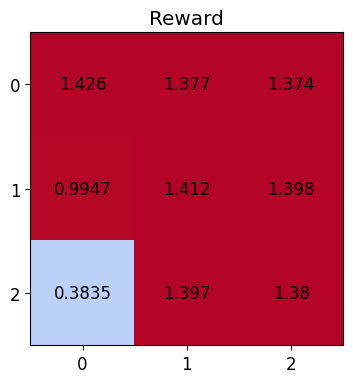

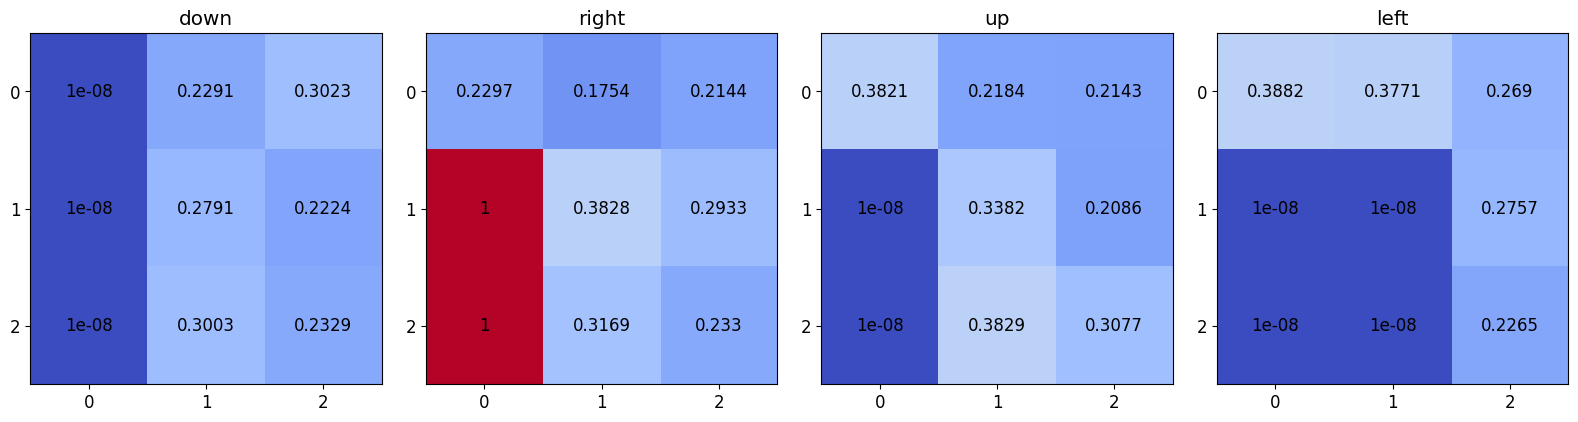

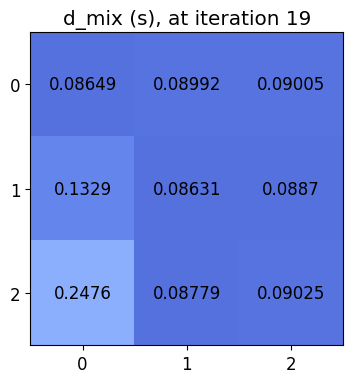

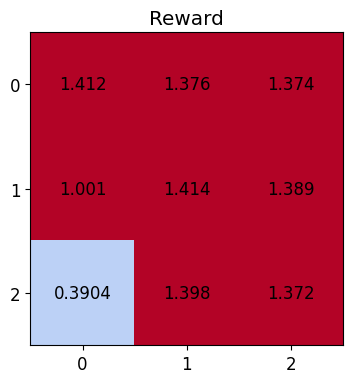

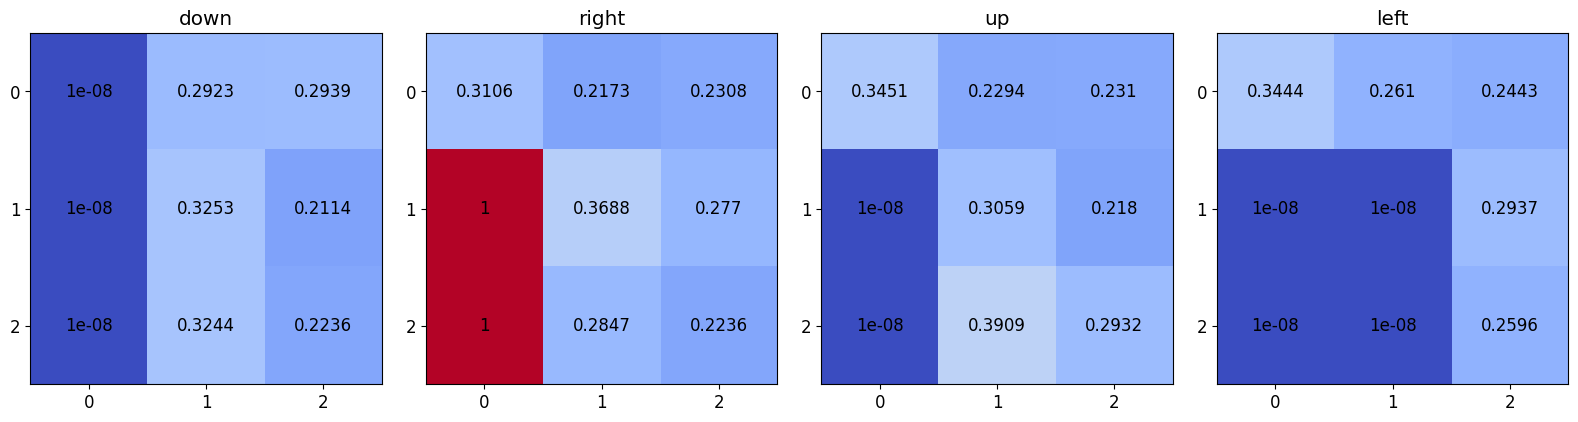

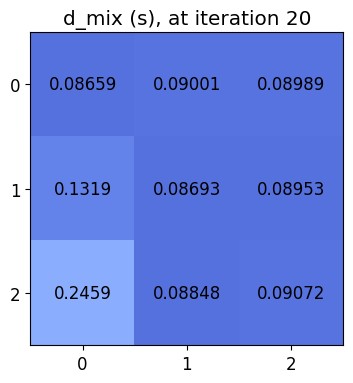

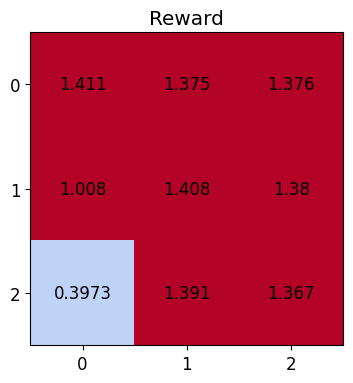

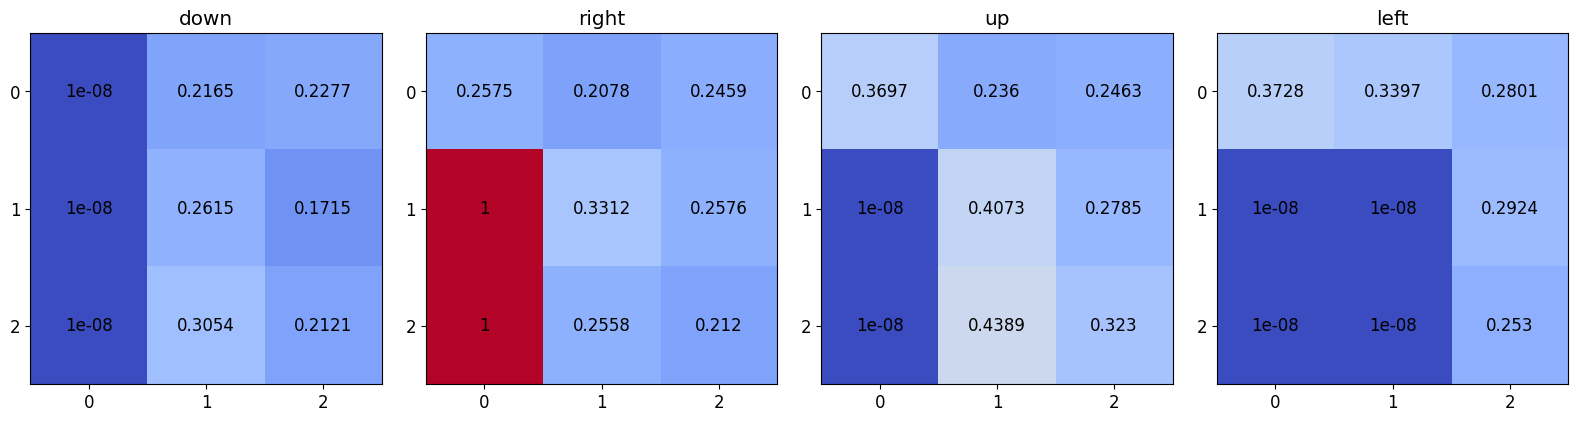

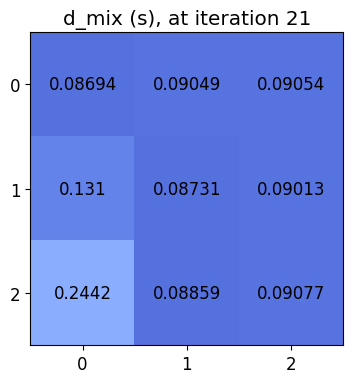

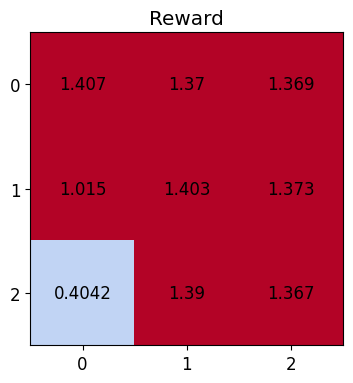

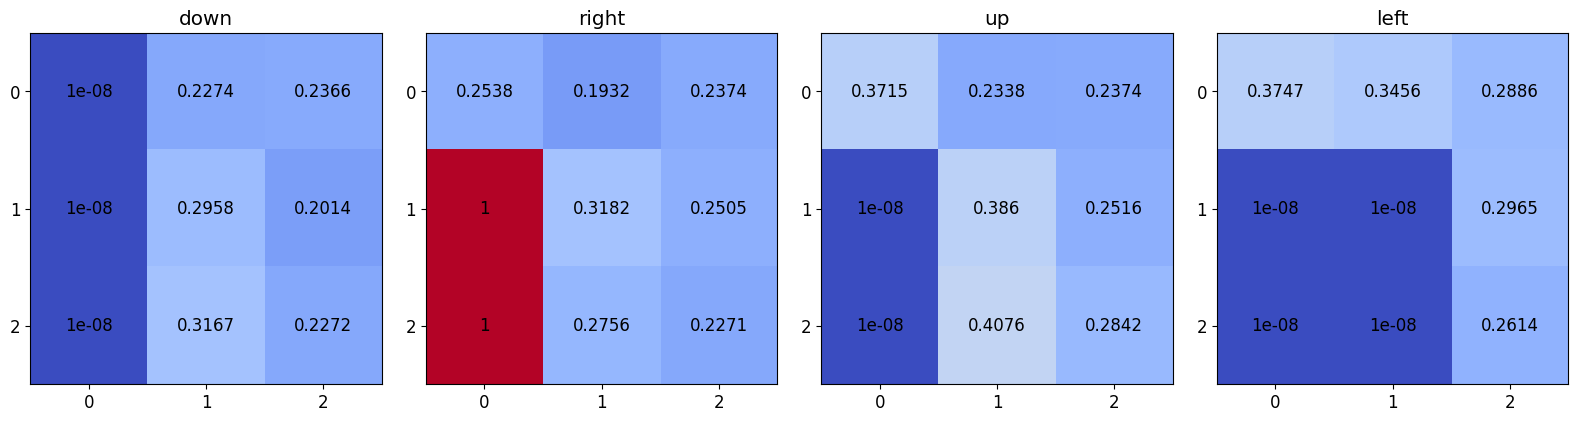

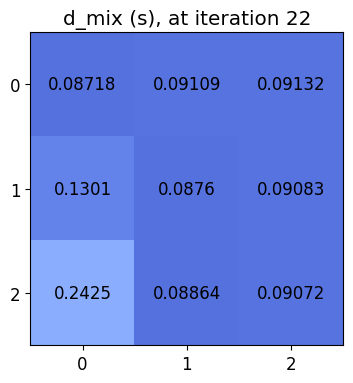

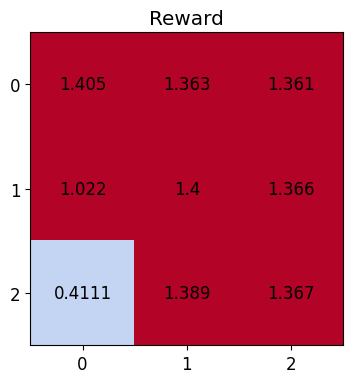

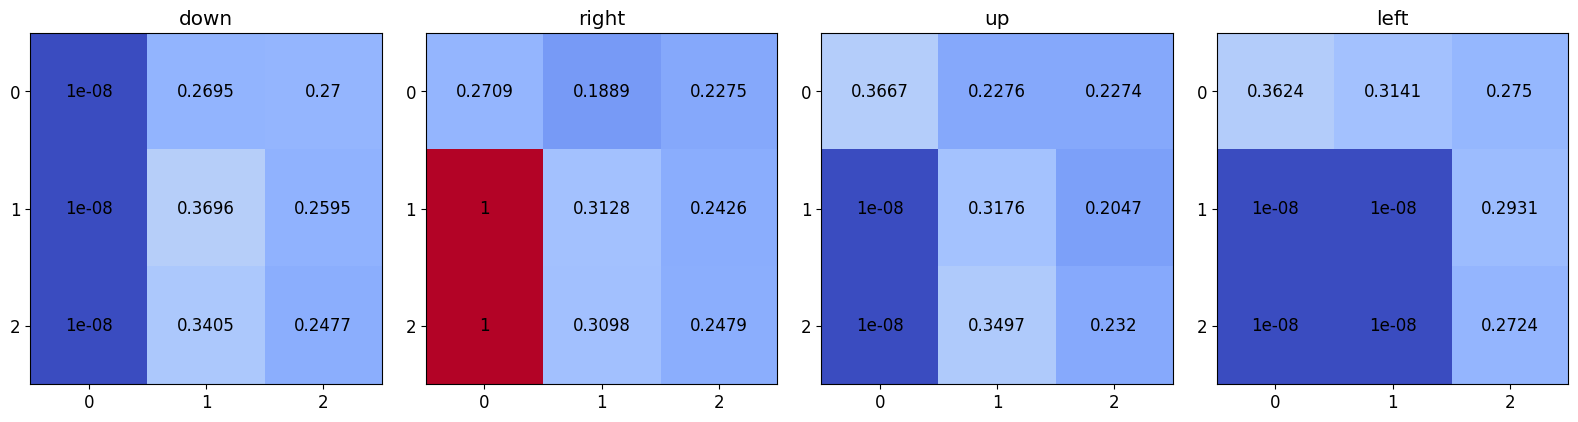

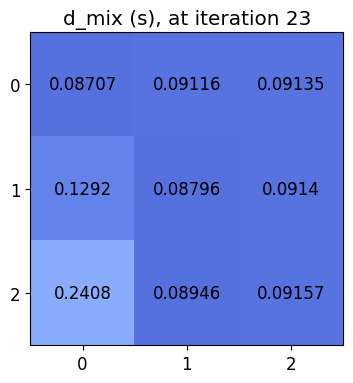

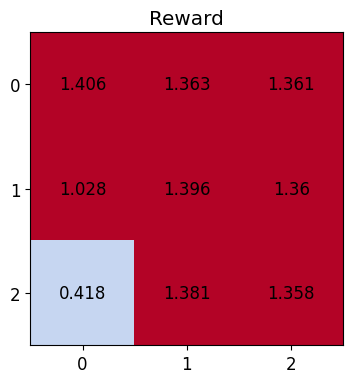

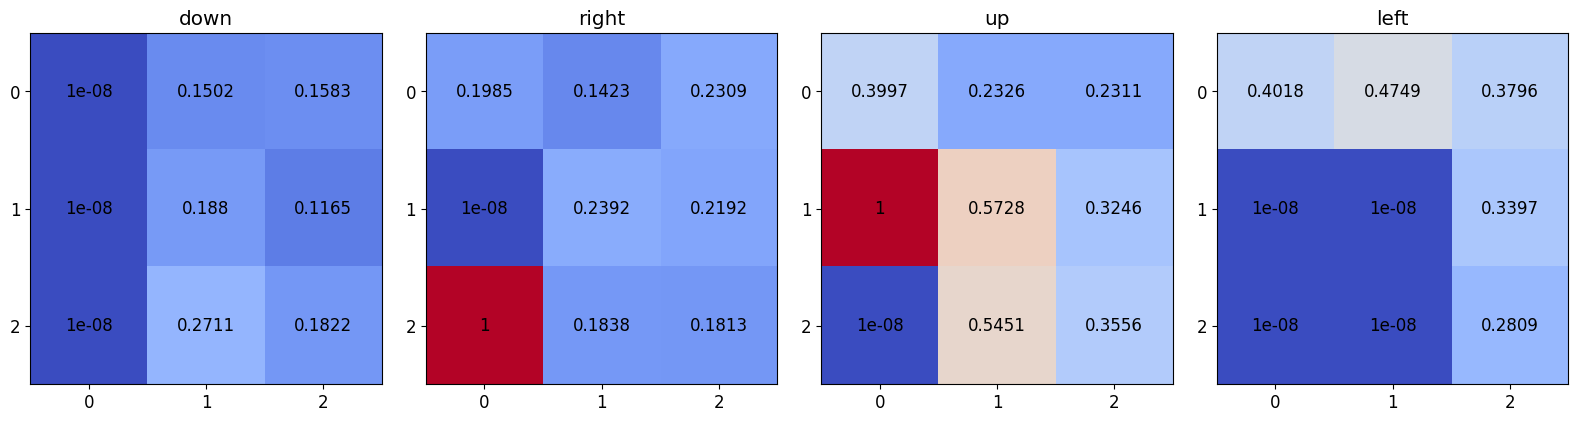

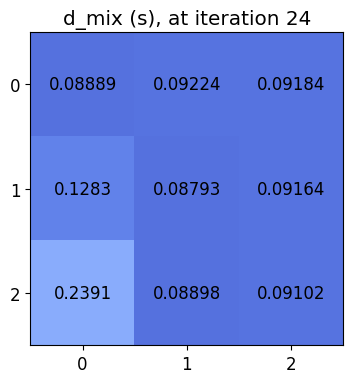

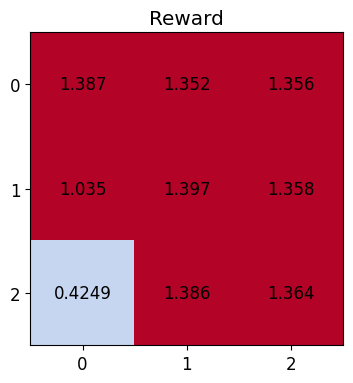

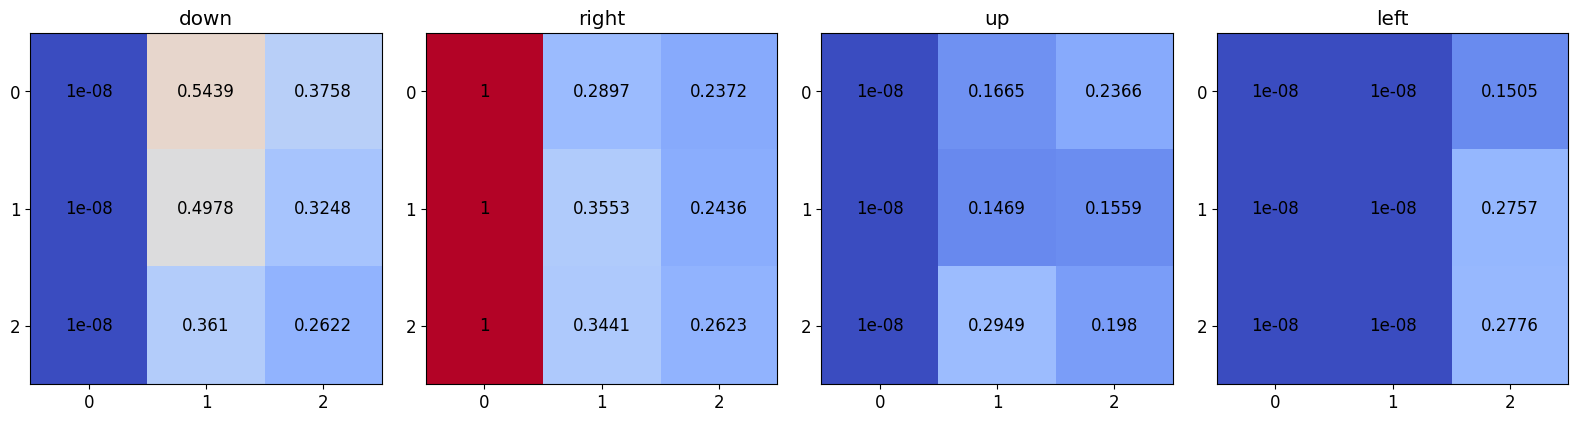

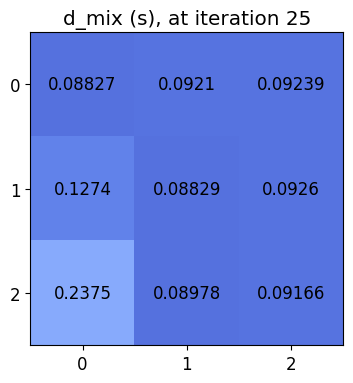

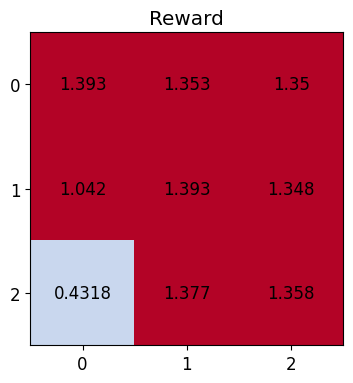

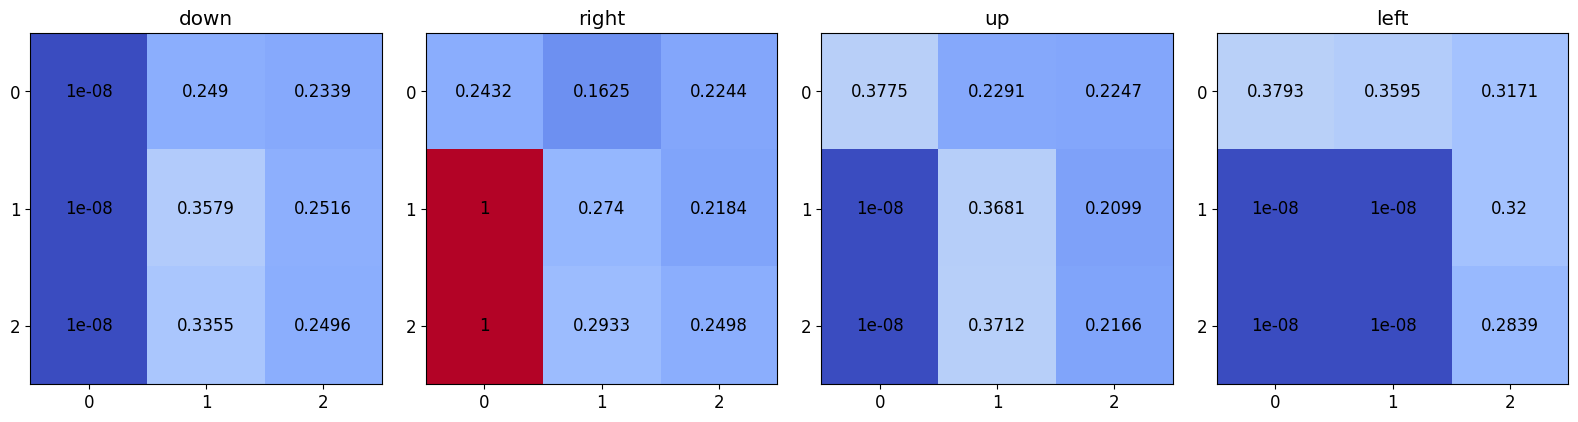

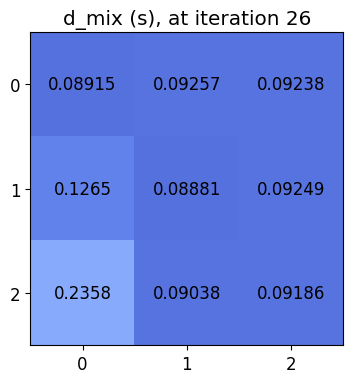

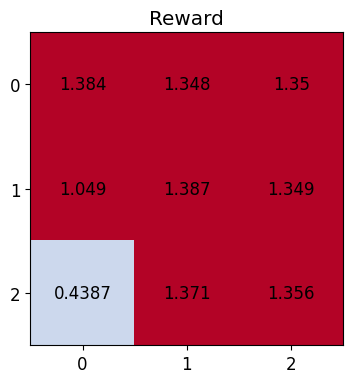

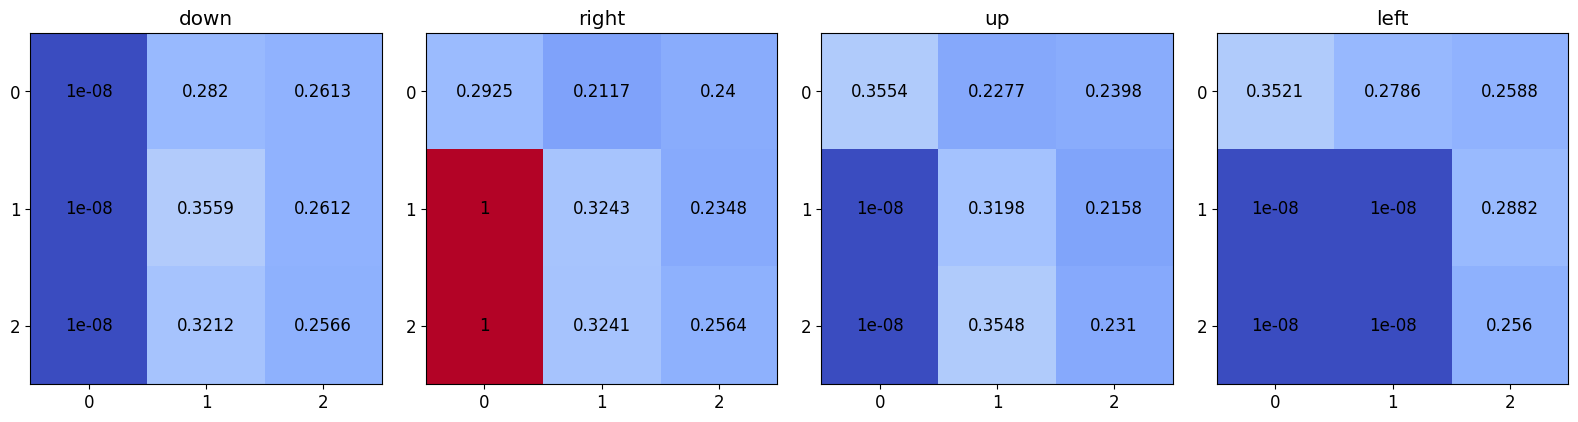

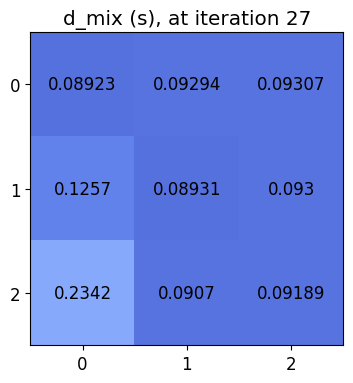

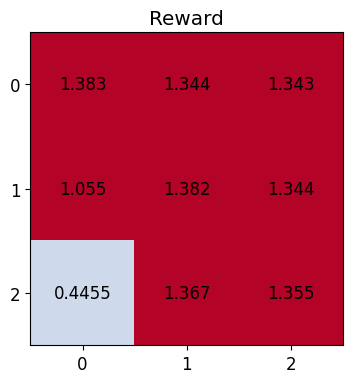

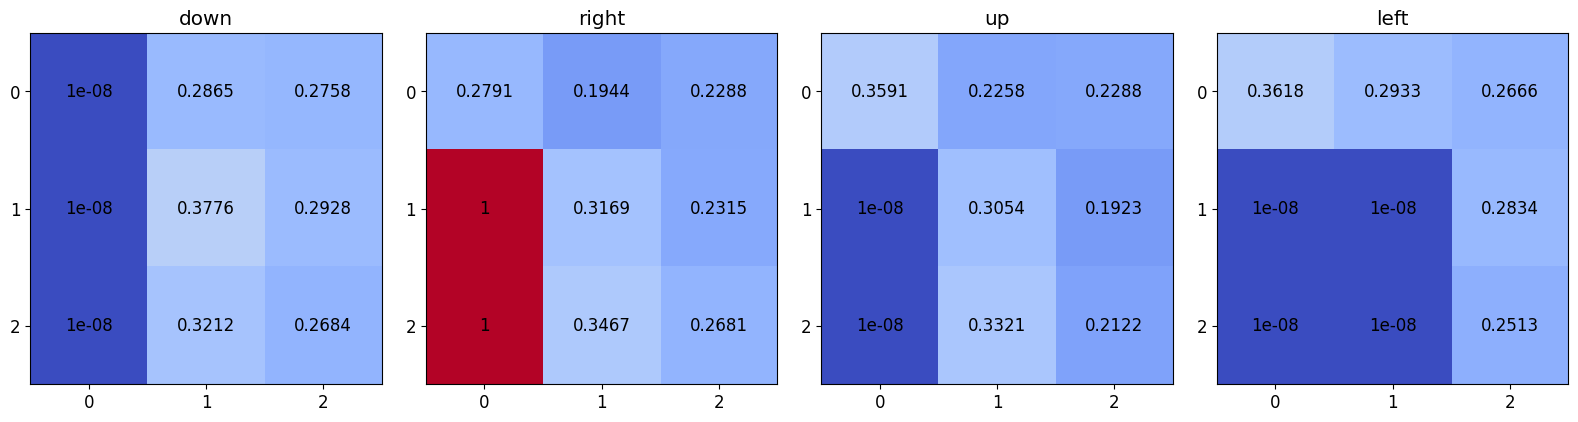

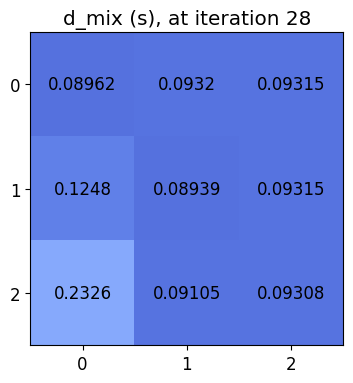

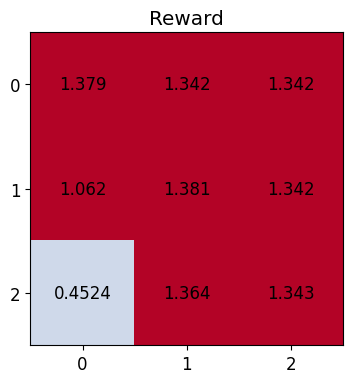

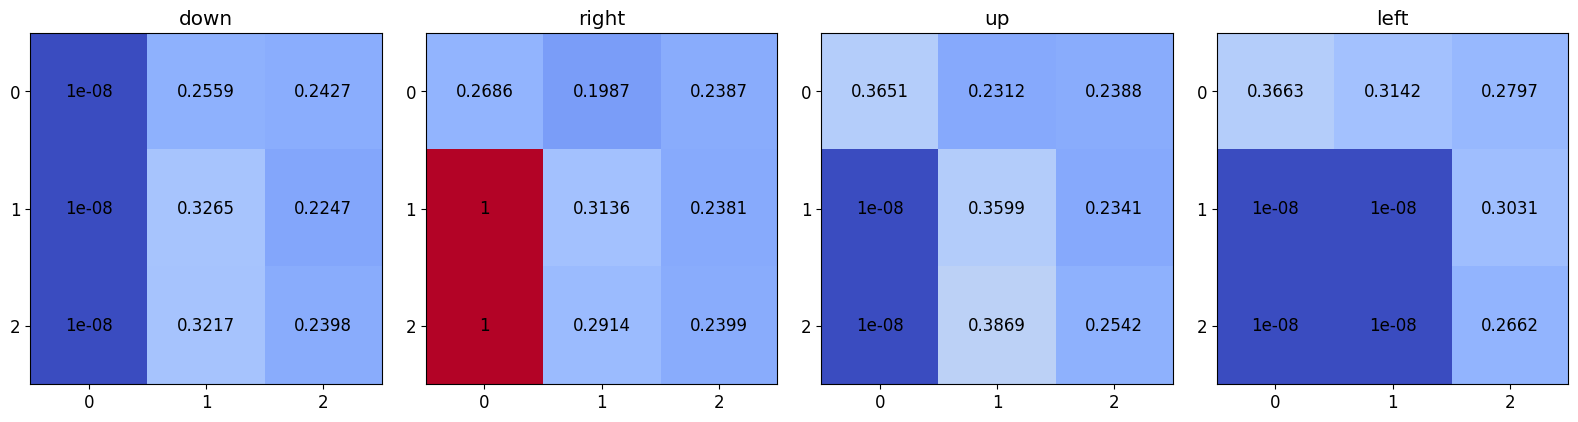

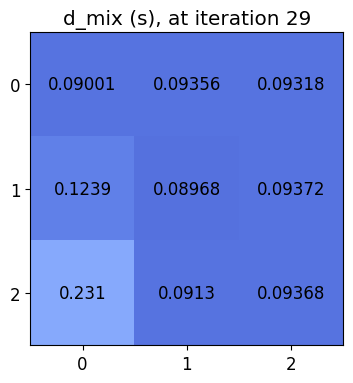

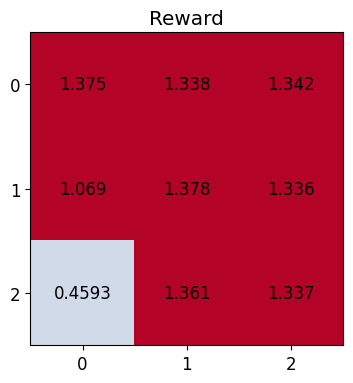

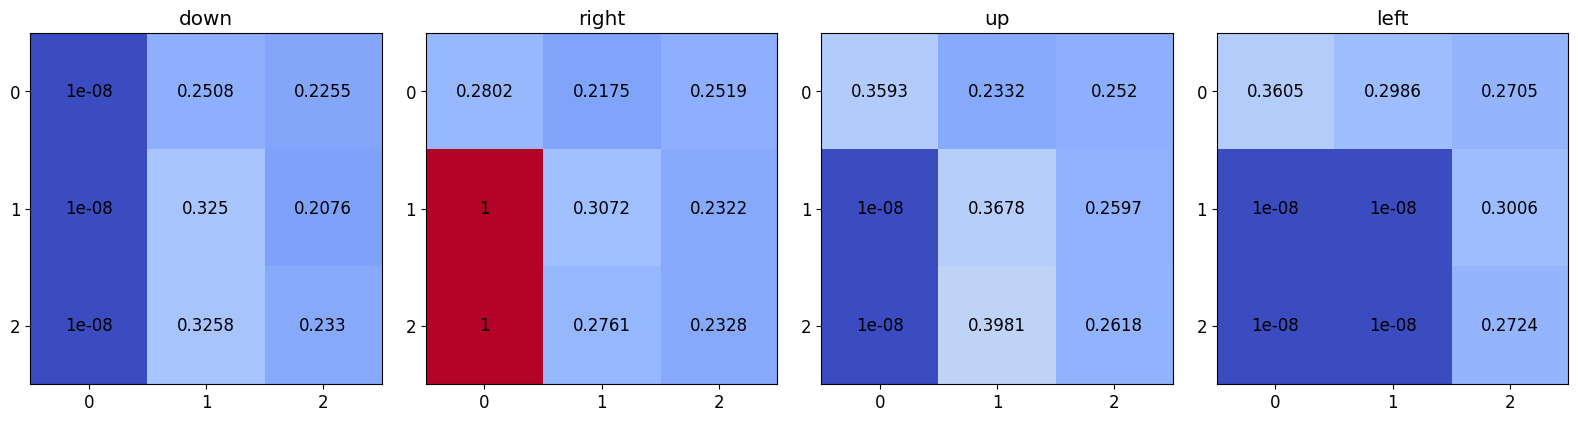

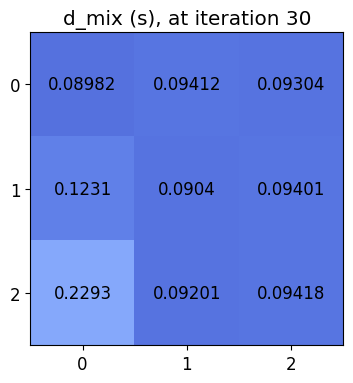

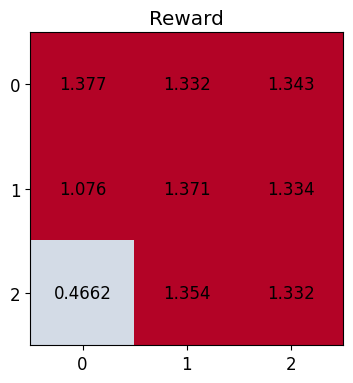

KeyboardInterrupt: 

In [230]:
#Frank Wolfe Algorithm

#Constants
size_S = 3**2
size_A = 4
dim_S = 3
discount_factor = 0.9
learning_rate = 0.2
train_episodes = 6000
steps = 150
threshold = 0
eps=5
eps0 = 0.1*eps**2/(80*env.S)
sigma = 0.1*eps / (2*env.S)
rho = np.array([[1,1,1],
                [1,1,1],
                [1,1,1]])/9
K = 15
eta = 0.1*eps**2/(40*env.S)

#Initialise the ReLOAD policy - starting policy of solving the CMDP
ReLOAD_policy = DirectParamPolicy(3, 4)
ReLOAD_policy.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
ReLOAD_policy.updateDistribution()

#Initialise the environment for the first density oracle
env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,\
    rewards= np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]]), costs = np.array([[0,0,0],[0,0,0],[0,0,0]]))

density_list = []


#Initialisation of the policy that we will iterate over
policy = DirectParamPolicy(env.size, env.A)
policy.params = np.array([
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]],
        
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]],
        
                          [[0.5, 0.1, 0.2, 0.2],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.1, 0.1, 0.4, 0.4]]
                        ])
policy.updateDistribution()
policy.plotPolicy()
plt.show()

#Estimate the first density
d_s_mix = DensityEstimation(env, policy, M=30000, t0=140)
PlotD(d_s_mix, 'State distribution')
density_list.append(d_s_mix)

d_sa_mix = StateToStateAction(policy, d_s_mix)

for t in range(60):
    
    #Calculate the reward
    dR = -(d_s_mix/(d_s_mix+sigma)+np.log(d_s_mix+sigma))
    PlotD(dR, 'Reward')
    
    #Reset the parameters of the reload policy - potentially not required
    ReLOAD_policy.params = np.array([
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]],
        
                          [[0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25],
                           [0.25, 0.25, 0.25, 0.25]]
                        ])
    ReLOAD_policy.updateDistribution()
    
    #Initialise the environment
    env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
                  rewards= -dR/np.sum(dR), costs = np.array([[0,0,0],[0,0,0],[0,0,0]]))

    #Calculate the new policy
    new_policy, Qr, Qc, mu_list = ReLOAD(env, rho, K, size_A, dim_S, train_episodes, steps, discount_factor, ReLOAD_policy, ReLOAD_policy, threshold)
    
    env.close()

    PlotQ(new_policy.params)
    
    #Initialise the environment
    env = gym.make('gym_examples/GridWorld-v3', render_mode=None, size=3,
                  rewards= -dR/np.sum(dR), costs = np.array([[0,0,0],[0,0,0],[0,0,0]]))
    d_s = DensityEstimation(env, new_policy, M=10, t0=1000)

    d_sa = StateToStateAction(new_policy, d_s)

    d_sa_mix = (1 - eta) * d_sa_mix + eta * d_sa

    d_s_mix = StateActionToState(d_sa_mix)

    PlotD(d_s_mix, f'd_mix (s), at iteration {t}')

In [380]:
size_S = 3**2
size_A = 4
dim_S = 3
discount_factor = 0.99
learning_rate = 0.2
train_episodes = 6000#7000
steps = 100
threshold = 0
eps=5
eps0 = 0.1*eps**2/(80*env.S)
sigma = 0.1*eps / (2*env.S)
rho = np.array([[1,1,1],
                [1,1,1],
                [1,1,1]])/9
K = 15 #20
eta = 0.1*eps**2/(40*env.S)*100
print(eta)


0.6944444444444444


1000 1000


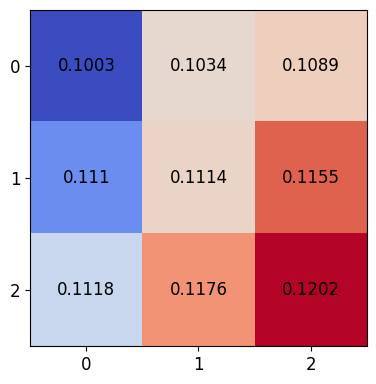